In [1]:
import seaborn as sns
import bokeh.plotting as blt
import bokeh.models as bmod
import matplotlib as mpl
import matplotlib.cm as cm
from statsmodels.api import formula as sm
import sklearn as sk
from sklearn import tree
import pydotplus
from IPython.display import Image
import matplotlib
import matplotlib.cm as cm
from scipy.interpolate import griddata
import scipy

def standardize(x):
    '''Use on a pd.series'''
    
    mn = np.nanmean(x)
    sd = np.nanstd(x)
    
    x2 = (x-mn)/sd
    
    return x2

sns.set_style('white')

In [2]:
def z_test(mod1,mod2,param):
    ''' model1, model2, coefficient name
    mod1 = model1
    mod2 = model2
    param = coefficient name
    
    From:
    Paternoster, R., Brame, R., Mazerolle, P., & Piquero, A. R. (1998). Using the Correct Statistical Test for the 
    Equality of Regression Coefficients. Criminology, 36(4), 859–866.'''
    
    b1 = mod1.params[param]
    b2 = mod2.params[param]
    SEb1 = np.square(mod1.bse[param])
    SEb2 = np.square(mod2.bse[param])
    
    Z = (b1-b2)/np.sqrt(SEb1+SEb2)
    
    pval = scipy.stats.norm.sf(abs(Z))
    
    return Z,pval

In [3]:
def process_df(data,soils):
    
    data.PeakSWE *= 1000. # convert m to mm
    data.SMR *= 1000. # convert m/d to mm/d
    data.MAP *= 1000. # convert m to mm
    
    data['Pmodel'] = data['PeakSWE'] + data['p'] # this is all of the precip data fed into the  model + peak swe
    data['Pex'] = data['PeakSWE'] + data['MAP'] # this is all of the precip that the model should see in liquid form + peak swe
    data['wb'] = data['PeakSWE'] - (data['ET']+data['Q'])
    data['RR'] = data.Q/data.Pex
    #data['Qerr'] = data.Q-data.streamflow
    data['ablRR'] = data.Q/data.PeakSWE
    data['RR_ET'] = 1-data.ET/data.Pex
    data['ablRR_ET'] = 1-(data.ET/data.PeakSWE)
    # create some normalized variables
    data['SMR_PeakSWE'] = data.SMR/data.PeakSWE
    data['TpeakSWE_PeakSWE'] = data.SMR/data.PeakSWE

    # standardize variables
    data['ablRR2'] = standardize(data.ablRR)
    data['RR2'] = standardize(data.RR)
    data['RR_ET2'] = standardize(data.RR_ET)
    data['ablRR_ET2'] = standardize(data.ablRR_ET)
    data['SMR2'] = standardize(data.SMR)
    data['PeakSWE2'] = standardize(data.PeakSWE)
    data['TpeakSWE2'] = standardize(data.TpeakSWE)
    data['SMR_PeakSWE2'] = standardize(data.SMR_PeakSWE)
    data['TpeakSWE_PeakSWE2'] = standardize(data.TpeakSWE_PeakSWE)
    data['wb2'] = standardize(data.wb)
    
    soils['multi_intercept'] = np.NaN
    soils['multi_SMR_coef'] = np.NaN
    soils['multi_TpeakSWE_coef'] = np.NaN
    soils['multi_PeakSWE_coef'] = np.NaN
    soils['multi_mod_r2'] = np.NaN
    soils['mulit_SMR_SE'] = np.NaN
    soils['mulit_TpeakSWE_SE'] = np.NaN
    soils['mulit_PeakSWE_SE'] = np.NaN
    
    soils['single_SMR_intercept'] = np.NaN
    soils['single_SMR_coef'] = np.NaN
    soils['single_SMR_r2'] = np.NaN
    
    soils['single_PeakSWE_intercept'] = np.NaN
    soils['single_PeakSWE_coef'] = np.NaN
    soils['single_PeakSWE_r2'] = np.NaN
    
    soils['single_TpeakSWE_intercept'] = np.NaN
    soils['single_TpeakSWE_coef'] = np.NaN
    soils['single_TpeakSWE_r2'] = np.NaN
    
    soils['wb_intercept'] = np.NaN
    soils['wb_TpeakSWE_coef'] = np.NaN
    soils['wb_SMR_coef'] = np.NaN
    soils['wb_r2'] = np.NaN
    soils['wb_pval'] = np.NaN
    
    soils['wb_ablRR_ET_intercept'] = np.NaN
    soils['wb__ablRR_ET_coef'] = np.NaN
    soils['wb_ablRR_ET_r2'] = np.NaN
    soils['wb_ablRR_ET_pval'] = np.NaN
    
    return data,soils

### Nr1

In [4]:
site = 'Nr1'
exname = 'smex7_sen'
method = '7'
period = 'melt'

data = pd.read_hdf('./data/%s_%s_%s.hdf'%(site,exname,period),'df') # load the first experiment
soils = pd.read_pickle('./data/soils_%s_smex%s_storage_drainage.pcl'%(site,method))

Nr1,soils_nr1 = process_df(data,soils)

soils_nr1['Site'] = 'Nr1'

### P301

In [5]:
site = 'p301'
exname = 'smex7_sen'
method = '7'
period = 'melt'

data = pd.read_hdf('./data/%s_%s_%s.hdf'%(site,exname,period),'df') # load the first experiment
soils = pd.read_pickle('./data/soils_%s_smex%s_storage_drainage.pcl'%(site,method))

P301,soils_p301 = process_df(data,soils)

soils_p301['Site'] = 'P301'

### Vcm

In [6]:
site = 'Vcm'
exname = 'smex7_sen'
method = '7'
period = 'melt2'

data = pd.read_hdf('./data/%s_%s_%s.hdf'%(site,exname,period),'df') # load the first experiment
soils = pd.read_pickle('./data/soils_%s_smex%s_storage_drainage.pcl'%(site,method))

Vcm,soils_vcm = process_df(data,soils)

soils_vcm['Site'] = 'Vcm'

In [7]:
# clean the data to remove scenarios where ET is greater than snowmelt
Nr1 = Nr1.loc[Nr1.ablRR_ET>0]
P301 = P301.loc[P301.ablRR_ET>0]
Vcm = Vcm.loc[Vcm.ablRR_ET>0]

In [8]:
soils = pd.concat([soils_nr1,soils_p301,soils_vcm],axis=0)

In [9]:
datasets = [Nr1,P301,Vcm] # list of data frames
sites = ['Nr1','P301','Vcm'] # list of site names

In [10]:
combos = soils.combo.unique()

In [11]:
combo_list = []
models = []
site_list = []

for dat,site in zip(datasets,sites): # loop through each site 
    for combo in combos: # loop through each combination
        
        # fit a multiple linear regression model
        mod = sm.ols('ablRR_ET2 ~ SMR2 + TpeakSWE2 + 1',data=dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.combo == combo),'multi_TpeakSWE_coef'] = mod.params['TpeakSWE2']
        #soils.loc[(soils.Site == site) & (soils.combo == combo),'multi_PeakSWE_coef'] = mod.params['PeakSWE2']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'multi_SMR_coef'] = mod.params['SMR2']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'multi_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'multi_mod_r2'] = mod.rsquared
        soils.loc[(soils.Site == site) & (soils.combo == combo),'multi_mod_pval'] = mod.f_pvalue
        
        combo_list.append(combo)
        models.append(mod)
        site_list.append(site)
        
        # fit single relationships
        mod = sm.ols('ablRR_ET ~ SMR + 1',data=dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.combo == combo),'single_SMR_coef'] = mod.params['SMR']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'single_SMR_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'single_SMR_r2'] = mod.rsquared
        
        mod = sm.ols('ablRR_ET ~ PeakSWE + 1',data=dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.combo == combo),'single_PeakSWE_coef'] = mod.params['PeakSWE']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'single_PeakSWE_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'single_PeakSWE_r2'] = mod.rsquared
        
        mod = sm.ols('ablRR_ET ~ TpeakSWE + 1',data=dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.combo == combo),'single_TpeakSWE_coef'] = mod.params['TpeakSWE']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'single_TpeakSWE_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'single_TpeakSWE_r2'] = mod.rsquared
        
        mod = sm.ols('wb2 ~ SMR2 + TpeakSWE2 + 1', data = dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.combo == combo),'wb_TpeakSWE_coef'] = mod.params['TpeakSWE2']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'wb_SMR_coef'] = mod.params['SMR2']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'wb_SMR_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'wb_r2'] = mod.rsquared
        soils.loc[(soils.Site == site) & (soils.combo == combo),'wb_pval'] = mod.f_pvalue
        
        mod = sm.ols('ablRR_ET2 ~ wb2 + 1', data = dat.loc[dat.combo == combo]).fit()
        soils.loc[(soils.Site == site) & (soils.combo == combo),'wb_ablRR_ET_coef'] = mod.params['wb2']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'wb_ablRR_ET_intercept'] = mod.params['Intercept']
        soils.loc[(soils.Site == site) & (soils.combo == combo),'wb_ablRR_ET_r2'] = mod.rsquared
        soils.loc[(soils.Site == site) & (soils.combo == combo),'wb_ablRR_ET_pval'] = mod.f_pvalue
        

In [12]:
soils.loc[soils.combo=='d3:s3',['wb_ablRR_ET_coef','wb_ablRR_ET_intercept','wb_ablRR_ET_r2','wb_ablRR_ET_pval','Site']]

wb_ablRR_ET_coef  wb_ablRR_ET_intercept  wb_ablRR_ET_r2  wb_ablRR_ET_pval  \
12          0.529026              -0.004399        0.275425      0.000000e+00   
12          0.166658              -0.000018        0.027742      3.965968e-63   
12          0.591448               0.012709        0.480857      0.000000e+00   

    Site  
12   Nr1  
12  P301  
12   Vcm

In [14]:
soils.loc[soils.combo=='d3:s3',['multi_SMR_coef','multi_TpeakSWE_coef','multi_mod_r2','multi_mod_pval','Site']]

multi_SMR_coef  multi_TpeakSWE_coef  multi_mod_r2  multi_mod_pval  Site
12        0.460155            -0.702198      0.682535    0.000000e+00   Nr1
12        0.720515            -0.437847      0.680263    0.000000e+00  P301
12        0.079475             0.214521      0.073539   1.576502e-165   Vcm

In [13]:
mods = pd.DataFrame({'site':site_list,'combo':combo_list,'model':models})

In [15]:
tmp = pd.DataFrame(columns=list(mods.loc[mods.site == 'Nr1','combo']),index=list(mods.loc[mods.site == 'Nr1','combo']),dtype=np.float64)

In [16]:
P301_SMR = tmp.copy()
Vcm_SMR = tmp.copy()
Nr1_SMR = tmp.copy()

P301_TpeakSWE = tmp.copy()
Vcm_TpeakSWE = tmp.copy()
Nr1_TpeakSWE = tmp.copy()

In [17]:
for site,df in zip(['P301','Vcm','Nr1'],[P301_SMR,Vcm_SMR,Nr1_SMR]):
    param = 'SMR2'
    for col in combos:
        for row in combos:
            mod1 = mods.loc[(mods.site==site) & (mods.combo == col),'model'].as_matrix()[0]
            mod2 = mods.loc[(mods.site==site) & (mods.combo == row),'model'].as_matrix()[0]

            z,p = z_test(mod1,mod2,param)

            df.loc[col,row] = p

In [18]:
for site,df in zip(['P301','Vcm','Nr1'],[P301_TpeakSWE,Vcm_TpeakSWE,Nr1_TpeakSWE]):
    param = 'TpeakSWE2'
    for col in combos:
        for row in combos:
            mod1 = mods.loc[(mods.site==site) & (mods.combo == col),'model'].as_matrix()[0]
            mod2 = mods.loc[(mods.site==site) & (mods.combo == row),'model'].as_matrix()[0]

            z,p = z_test(mod1,mod2,param)

            df.loc[col,row] = p

In [19]:
from itertools import combinations

In [20]:
tmp = []
for cmb in combinations(combos,2):
    tmp.append(cmb)

In [21]:
df = Vcm
(sm.ols('wb ~ SMR2 + TpeakSWE2 + 1', data = df.loc[df.combo=='d3:s3']).fit()).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     wb   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     25.91
Date:                Tue, 27 Jun 2017   Prob (F-statistic):           5.96e-12
Time:                        13:41:13   Log-Likelihood:                -59521.
No. Observations:                9939   AIC:                         1.190e+05
Df Residuals:                    9936   BIC:                         1.191e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    160.3980      0.968    165.650      0.000       158.500   162.296
SMR2           0.1085      0.969      0.112      0.911        -1.792     2.009
TpeakSWE2      6.9631      0.968      7.197      0.000         5.066     8.860
==============================================================================
Omnibus:                    10188.584   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              617.190
Skew:                           0.048   Prob(JB):                    9.52e-135
Kurtosis:                       1.783   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

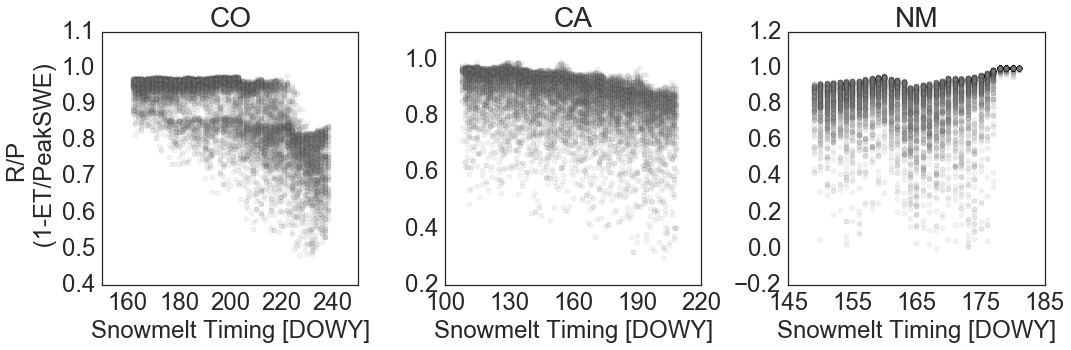

In [22]:
y = 'ablRR_ET'
ylab = 'R/P \n (1-ET/PeakSWE)'
x = 'TpeakSWE'
xlab = 'Snowmelt Timing [DOWY]'
#c = 'PeakSWE'
#clab = 'Snowmelt Timing [DOWY]'
s = 25
cmap='Reds'
xmin = -200
xmax = 1600
vmin = 0
vmax = 1600
ymin = 0.4
ymax = 1.0
axfont = 24
titlefont = 28

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
df = Nr1
#ax.hexbin(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],gridsize=20)
#ax.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],s=s, c = df.loc[df.combo == 'd3:s3',c],cmap=cmap,vmin=vmin,vmax=vmax)
ax.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],s=s, c = '0.5',alpha=0.1)
ax.set_xlabel(xlab,fontsize=axfont)
ax.set_ylabel(ylab,fontsize=axfont)
ax.set_title('CO',fontsize=titlefont)
#ax.set_xticks(np.linspace(50,650,num=5,endpoint=True))
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
[tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];

ax = fig.add_subplot(132)
df = P301
#ax.hexbin(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],gridsize=20)
#ax.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],s=s, c = df.loc[df.combo == 'd3:s3',c],cmap=cmap,vmin=vmin,vmax=vmax)
ax.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],s=s, c = '0.5',alpha=0.1)
ax.set_xlabel(xlab,fontsize=axfont)
ax.set_title('CA',fontsize=titlefont)
ax.set_xticks(np.linspace(100,220,num=5,endpoint=True))
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
[tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];

ax = fig.add_subplot(133)
df = Vcm
#ax.hexbin(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],gridsize=20)
#plt.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],s=s, c = df.loc[df.combo == 'd3:s3',c],cmap=cmap,vmin=vmin,vmax=vmax)
plt.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],s=s, c = '0.5',alpha=0.1)
plt.xlabel(xlab,fontsize=axfont)
plt.title('NM',fontsize=titlefont)
#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)
plt.xticks(np.linspace(145,185,num=5,endpoint=True))
[tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];
#cb = plt.colorbar()
#cb.set_label(clab, fontsize=22)
#cb.ax.tick_params(labelsize=18) 
#cb.set_alpha(1)
#cb.draw_all()

plt.tight_layout()
#plt.savefig('./figures/smex7_TpeakSWE_ablRR_ET.png',dpi=300,bbox_inches='tight')

In [23]:
Nr1.head()

MAP     PeakSWE       SMR  TpeakSWE  combo  idx     ksat       m  \
0  6165.934875  413.660073  7.447322     180.0  d1:s1    0  10.0245  4.9592   
1  6165.934875  413.660073  7.447322     180.0  d1:s2    0  10.0245  4.9592   
2  6165.934875  413.660073  7.447322     180.0  d1:s3    0  10.0245  4.9592   
3  6165.934875  413.660073  7.447322     180.0  d1:s4    0  10.0245  4.9592   
4  6165.934875  413.660073  7.447322     180.0  d1:s5    0  10.0245  4.9592   

        pa        po    ...       ablRR2       RR2    RR_ET2  ablRR_ET2  \
0  0.00356  0.032637    ...    -0.521542 -0.468064  0.320272   0.426511   
1  0.00534  0.032637    ...    -0.521535 -0.468055  0.313308   0.420764   
2  0.00712  0.032637    ...    -0.521507 -0.468025  0.320040   0.426320   
3  0.00890  0.032637    ...    -0.521434 -0.467948  0.320693   0.426859   
4  0.01068  0.032637    ...    -0.521363 -0.467871  0.315050   0.422202   

       SMR2  PeakSWE2  TpeakSWE2  SMR_PeakSWE2  TpeakSWE_PeakSWE2       wb2  
0 -1.011687  0.467175  -0.890476     -0.997594          -0.997594  0.675697  
1 -1.011687  0.467175  -0.890476     -0.997594          -0.997594  0.673338  
2 -1.011687  0.467175  -0.890476     -0.997594          -0.997594  0.675611  
3 -1.011687  0.467175  -0.890476     -0.997594          -0.997594  0.675816  
4 -1.011687  0.467175  -0.890476     -0.997594          -0.997594  0.673891  

[5 rows x 48 columns]

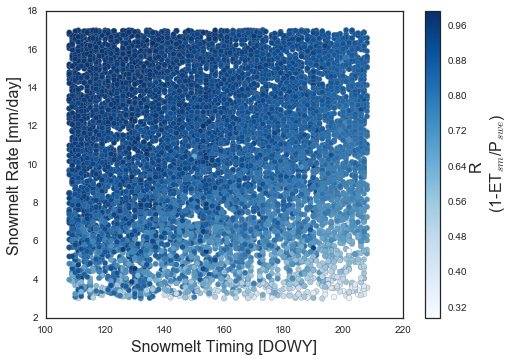

In [24]:
df = P301
df = df.loc[df.combo == 'd3:s3']

plt.scatter(df.TpeakSWE,df.SMR,s=30,c=df.ablRR_ET,cmap='Blues',edgecolor='0.5')
plt.ylabel('Snowmelt Rate [mm/day]', fontsize=16)
plt.xlabel('Snowmelt Timing [DOWY]', fontsize=16)
cb = plt.colorbar()
cb.set_label(label='R \n (1-ET$_{sm}$/P$_{swe}$)', fontsize=16)

In [25]:
def plt_smr_smt_grid(x,y,z,npts,nc,cmap,axfont,labels,ylab,xlab,clab):
    '''x = x axis variable
    y = y axis variable
    z = z axis variable
    npts = number of interpolation points along a side
nc = number of contour levels
cmap = colormap
axfont = axis font size
labels = titles
ylab = ylabel
xlab = xlabel
'''
    
    smts = [201,143,166]
    smrs = [11.6,0.007467*1000,0.004786*1000]
    
    dfs = [Nr1,P301,Vcm]
        
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    axes = [ax1,ax2,ax3]
    
    # Now add the colorbar
    cbax1 = fig.add_axes([0.125, -0.04, 0.225, 0.03])
    cbax2 = fig.add_axes([0.4, -0.04, 0.225, 0.03])
    cbax3 = fig.add_axes([0.4+(0.4-0.125), -0.04, 0.225, 0.03])
    #cbaxes = fig.add_axes([0.15, 0.3, 0.8, 0.1]) 
    
    
    cbaxes = [cbax1,cbax2,cbax3]
    
    ct = 0
    
    vmins = []
    vmaxs = []
    
    for df in [Nr1,P301,Vcm]:
        vmins.append(df[z].min())
        vmaxs.append(df[z].max())
    
    vmin = np.min(vmins)
    vmax = np.max(vmaxs)
    print vmin
    print vmax
    
    #cl = np.linspace(vmin,vmax,nc)
    
    for df,ax,label,cbax,smt,smr in zip(dfs,axes,labels,cbaxes,smts,smrs):
        df = df.loc[(df.combo == 'd3:s3') & (df.ablRR_ET>=0)]
        
        ymin = df[y].min()
        ymax = df[y].max()
        xmin = df[x].min()
        xmax = df[x].max()
        
        zmin = df[z].min()
        zmax = df[z].max()
        
        cl = np.linspace(zmin,zmax,nc)
        
        xi = np.linspace(xmin,xmax,npts) # create the grid
        yi = np.linspace(ymin,ymax,npts)
        
        zi = griddata((df[x], df[y]), df[z], (xi[None,:], yi[:,None]), method='linear') # interpolate
        
        #Cl = ax.contour(xi,yi,zi,contour_levels,linewidths=1,ls='-',colors='k',levels=contour_levels)
        Cf = ax.contourf(xi,yi,zi,cl,levels=cl,cmap=cmap)
        
        ax.set_ylim(ymin,ymax)
        ax.set_xlim(xmin,xmax)
        
        [tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
        [tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];
        
        ax.set_title(label,fontsize = axfont+2)
        if ct ==0:
            ax.set_ylabel(ylab,fontsize=axfont+2)
            
        ax.set_xlabel(xlab, fontsize=axfont+2)
        ax.plot(smt,smr,'*w',ms=25)
        ax.plot(smt,smr,'*k',ms=15)
        cb = plt.colorbar(Cf,cax = cbax,orientation='horizontal',format='%0.2f')
        cb.set_label(clab, fontsize=axfont-2)
        ct += 1
    
    #cb = plt.colorbar(Cf,cax = cbaxes,orientation='horizontal',format='%0.2f') 
    #cb.set_label('R\n(1-ET$_{sm}$/P$_{swe}$)', fontsize=14)

0.00147477162058
1.0


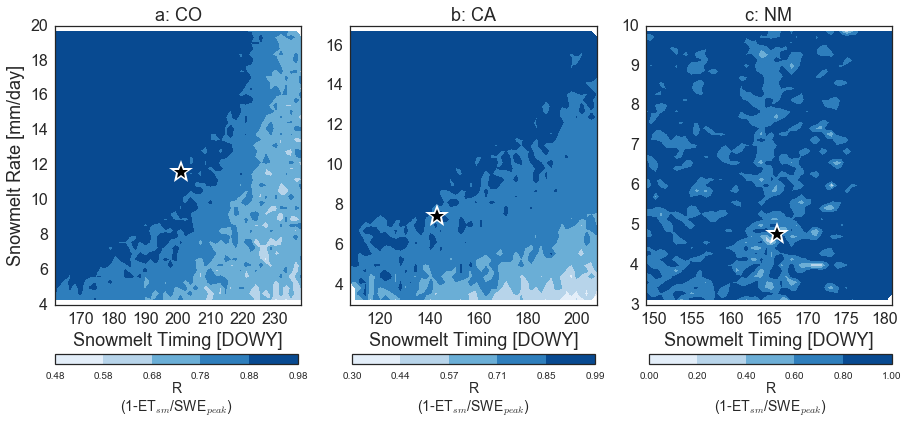

In [67]:
plt_smr_smt_grid('TpeakSWE','SMR','ablRR_ET',50,6,'Blues',16,['a: CO','b: CA','c: NM'],
                 'Snowmelt Rate [mm/day]','Snowmelt Timing [DOWY]',
                 'R\n(1-ET$_{sm}$/SWE$_{peak}$)')
plt.savefig('./figures/TpeakSWE_SMR_interp.png',dpi=300,bbox_inches='tight')
plt.savefig('./figures/TpeakSWE_SMR_interp.pdf',bbox_inches='tight')

-12.5408092245
1339.93120498


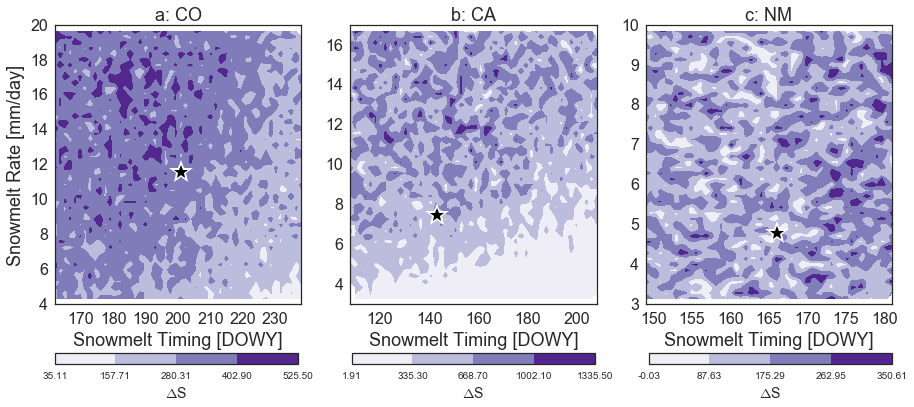

In [76]:
plt_smr_smt_grid('TpeakSWE','SMR','wb',50,5,'Purples',16,['a: CO','b: CA','c: NM'],
                 'Snowmelt Rate [mm/day]','Snowmelt Timing [DOWY]',
                 '$\Delta$S')
plt.savefig('./figures/TpeakSWE_wb_interp.png',dpi=300,bbox_inches='tight')
plt.savefig('./figures/TpeakSWE_wb_interp.pdf',bbox_inches='tight')

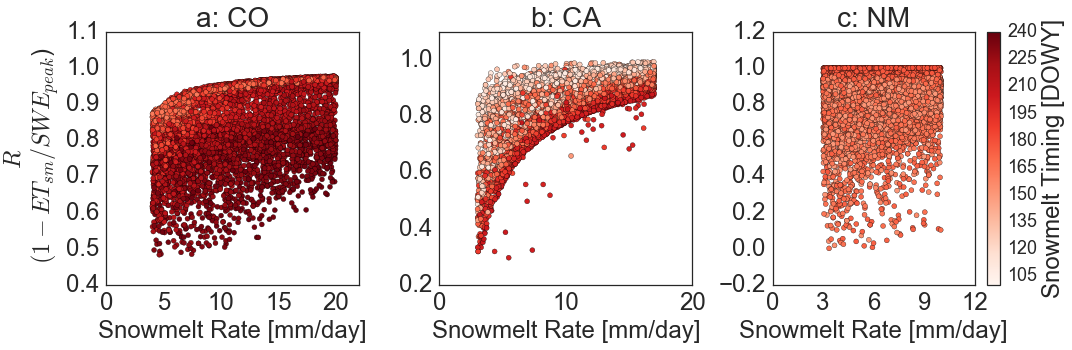

In [68]:
y = 'ablRR_ET'
ylab = '$R$ \n $(1-ET_{sm}/SWE_{peak}$)'
x = 'SMR'
xlab = 'Snowmelt Rate [mm/day]'
c = 'TpeakSWE'
clab = 'Snowmelt Timing [DOWY]'
s = 25
cmap='Reds'
xmin = -200
xmax = 1600
vmin = 100
vmax = 240
ymin = 0.4
ymax = 1.0
axfont = 24
titlefont = 28

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
df = Nr1
#ax.hexbin(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],gridsize=20)
ax.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],s=s, c = df.loc[df.combo == 'd3:s3',c],cmap=cmap,vmin=vmin,vmax=vmax)
ax.set_xlabel(xlab,fontsize=axfont)
ax.set_ylabel(ylab,fontsize=axfont)
ax.set_title('a: CO',fontsize=titlefont)
ax.set_xticks(np.linspace(0,20,num=5,endpoint=True))
ax.set_xlim(0,22)
#ax.set_ylim(ymin,ymax)
[tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];

ax = fig.add_subplot(132)
df = P301
#ax.hexbin(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],gridsize=20)
ax.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],s=s, c = df.loc[df.combo == 'd3:s3',c],cmap=cmap,vmin=vmin,vmax=vmax)
ax.set_xlabel(xlab,fontsize=axfont)
ax.set_title('b: CA',fontsize=titlefont)
ax.set_xticks(np.linspace(0,20,num=3,endpoint=True))
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
[tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];

ax = fig.add_subplot(133)
df = Vcm
#ax.hexbin(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],gridsize=20)
plt.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],s=s, c = df.loc[df.combo == 'd3:s3',c],cmap=cmap,vmin=vmin,vmax=vmax)
plt.xlabel(xlab,fontsize=axfont)
plt.title('c: NM',fontsize=titlefont)
#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)
plt.xticks(np.linspace(0,12,num=5,endpoint=True))
[tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];
cb = plt.colorbar()
cb.set_label(clab, fontsize=24)
cb.ax.tick_params(labelsize=18) 
cb.set_alpha(1)
cb.draw_all()

plt.tight_layout()
plt.savefig('./figures/smex7_SMR_RR_ET.png',dpi=300,bbox_inches='tight')
plt.savefig('./figures/smex7_SMR_RR_ET.pdf',bbox_inches='tight')

In [28]:
Nr1['gwStore2'] = standardize(Nr1.gwStore)
P301['gwStore2'] = standardize(P301.gwStore)
Vcm['gwStore2'] = standardize(Vcm.gwStore)

/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


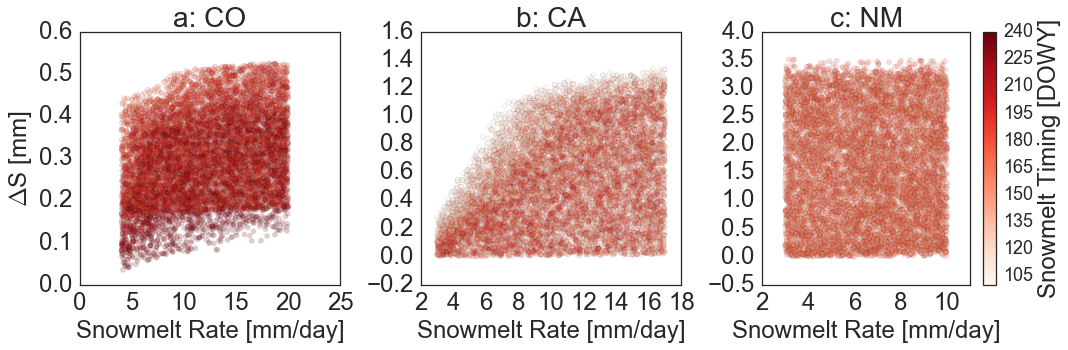

In [29]:
y = 'wb'
ylab = '$\Delta$S [mm]'
x = 'SMR'
xlab = 'Snowmelt Rate [mm/day]'
c = 'TpeakSWE'
clab = 'Snowmelt Timing [DOWY]'
s = 25
cmap='Reds'
xmin = -200
xmax = 1600
vmin = 100
vmax = 240
ymin = -0.015
ymax = 0.04
axfont = 24
titlefont = 28
alpha = 0.2

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
df = Nr1
#ax.hexbin(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],gridsize=20)
ax.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y]/1000.,s=s, c = df.loc[df.combo == 'd3:s3',c],cmap=cmap,vmin=vmin,vmax=vmax,alpha=alpha)
#ax.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y]/100.,s=s,c='0.5',alpha=0.1)
ax.set_xlabel(xlab,fontsize=axfont)
ax.set_ylabel(ylab,fontsize=axfont)
ax.set_title('a: CO',fontsize=titlefont)
#ax.set_xticks(np.linspace(0,600,num=5,endpoint=True))
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
[tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];

ax = fig.add_subplot(132)
df = P301
#ax.hexbin(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],gridsize=20)
ax.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y]/1000.,s=s, c = df.loc[df.combo == 'd3:s3',c],cmap=cmap,vmin=vmin,vmax=vmax,alpha=alpha)
#ax.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y]/100.,s=s,c='0.5',alpha=0.1)
ax.set_xlabel(xlab,fontsize=axfont)
ax.set_title('b: CA',fontsize=titlefont)
#ax.set_xticks(np.linspace(0,1600,num=5,endpoint=True))
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
[tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];

ax = fig.add_subplot(133)
df = Vcm
#ax.hexbin(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y],gridsize=20)
plt.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y]/100.,s=s, c = df.loc[df.combo == 'd3:s3',c],cmap=cmap,vmin=vmin,vmax=vmax,alpha=alpha)
#plt.scatter(df.loc[df.combo == 'd3:s3',x],df.loc[df.combo == 'd3:s3',y]/100.,s=s,c='0.5',alpha=0.1)
plt.xlabel(xlab,fontsize=axfont)
plt.title('c: NM',fontsize=titlefont)
#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)
plt.xticks(np.linspace(2,10,num=5,endpoint=True))
[tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];
cb = plt.colorbar()
cb.set_label(clab, fontsize=24)
cb.ax.tick_params(labelsize=18)
cb.set_alpha(alpha=1.)
cb.draw_all()

plt.tight_layout()
plt.savefig('./figures/smex7_SMR_delta_S_tpeakSWE.png',dpi=72,bbox_inches='tight',rasterize='True')
plt.savefig('./figures/smex7_SMR_delta_S_tpeakSWE.pdf',bbox_inches='tight')

In [30]:
def set_varID(var):
    if var=='multi_SMR_coef':
        return 1
    if var=='multi_TpeakSWE_coef':
        return 2
    if var=='multi_mod_r2':
        return 3

In [31]:
def fix_site(site):
    if site=='Nr1':
        return 'CO'
    if site == 'Vcm':
        return 'NM'
    if site == 'P301':
        return 'CA'

In [32]:
#tmp = soils.loc[soils.combo=='d3:s3',['multi_SMR_coef','multi_TpeakSWE_coef','multi_PeakSWE_coef','Site']]
tmp = soils.loc[soils.combo=='d3:s3',['multi_SMR_coef','multi_TpeakSWE_coef','multi_mod_r2','Site','multi_mod_pval']]

In [33]:
tmp.multi_SMR_coef = tmp.multi_SMR_coef.round(2)
tmp.multi_TpeakSWE_coef = tmp.multi_TpeakSWE_coef.round(2)
tmp.multi_mod_r2 = tmp.multi_mod_r2.round(2)

In [34]:
df = pd.melt(tmp,id_vars='Site')

In [35]:
df['varID'] = df.variable.map(set_varID)
df['Site'] = df.Site.map(fix_site)

[None]

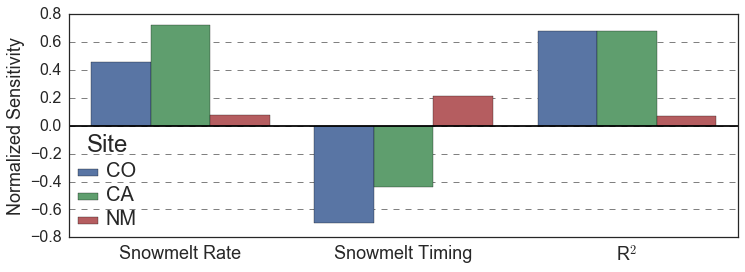

In [36]:
plt.figure(figsize=(12,4))
p = sns.barplot(x='varID', y='value',data=df,hue='Site')
p.set_xticklabels(['Snowmelt Rate','Snowmelt Timing','R$^2$'], fontsize=18)
p.set_xlabel('')
p.set_ylabel('Normalized Sensitivity', fontsize = 18)
[tick.label.set_fontsize(16) for tick in p.yaxis.get_major_ticks()];
#plt.title('Melt Season', fontsize = 16)
leg = plt.gca().get_legend()
ltext  = leg.get_texts()  # all the text.Text instance in the legend
ttext = leg.get_title()
plt.ylim(-0.8,0.8)
plt.axhline(0,c='k')
plt.grid(b=True, which='major', axis = 'y' ,color='0.5', linestyle='--')

plt.setp(ltext,fontsize=20)
plt.setp(ttext,fontsize=24)
#plt.savefig('./figures/melt_season_coef_comparision.png', dpi=300, bbox_inches='tight')
#plt.savefig('./figures/melt_season_coef_comparision.pdf', bbox_inches='tight')

In [37]:
tmp = soils.loc[soils.combo=='d3:s3',['wb_SMR_coef','wb_TpeakSWE_coef','wb_r2','Site','wb_pval']]

In [38]:
df = pd.melt(tmp,id_vars='Site')

In [39]:
def set_varID(var):
    if var=='wb_SMR_coef':
        return 1
    if var=='wb_TpeakSWE_coef':
        return 2
    if var=='wb_r2':
        return 3

In [40]:
df['varID'] = df.variable.map(set_varID)
df['Site'] = df.Site.map(fix_site)

[None]

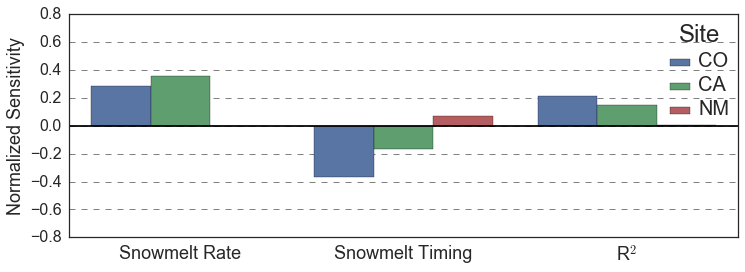

In [41]:
plt.figure(figsize=(12,4))
p = sns.barplot(x='varID', y='value',data=df,hue='Site')
p.set_xticklabels(['Snowmelt Rate','Snowmelt Timing','R$^2$'], fontsize=18)
p.set_xlabel('')
p.set_ylabel('Normalized Sensitivity', fontsize = 18)
[tick.label.set_fontsize(16) for tick in p.yaxis.get_major_ticks()];
#plt.title('Melt Season', fontsize = 16)
leg = plt.gca().get_legend()
ltext  = leg.get_texts()  # all the text.Text instance in the legend
ttext = leg.get_title()
plt.ylim(-0.8,0.8)
plt.axhline(0,c='k')
plt.grid(b=True, which='major', axis = 'y' ,color='0.5', linestyle='--')

plt.setp(ltext,fontsize=20)
plt.setp(ttext,fontsize=24)
#plt.savefig('./figures/melt_season_wb_closure_coefficients.png', dpi=300, bbox_inches='tight')
#plt.savefig('./figures/melt_season_wb_closure_coefficients.pdf', bbox_inches='tight')

In [90]:
tmp = soils.loc[(soils.Site=='P301') & (soils.combo=='d3:s3')]

In [91]:
print round(tmp.wb_SMR_coef,2)
print round(tmp.wb_TpeakSWE_coef,2)

0.36
-0.17


In [43]:
soils.multi_mod_pval.describe()

count     7.500000e+01
mean     3.796141e-153
std      1.199210e-152
min       0.000000e+00
25%       0.000000e+00
50%       0.000000e+00
75%      4.062304e-169
max      4.748884e-152
Name: multi_mod_pval, dtype: float64

In [44]:
df

Site          variable         value  varID
0    CO       wb_SMR_coef  2.827523e-01    1.0
1    CA       wb_SMR_coef  3.598885e-01    1.0
2    NM       wb_SMR_coef  1.113608e-03    1.0
3    CO  wb_TpeakSWE_coef -3.697179e-01    2.0
4    CA  wb_TpeakSWE_coef -1.659726e-01    2.0
5    NM  wb_TpeakSWE_coef  7.147393e-02    2.0
6    CO             wb_r2  2.130157e-01    3.0
7    CA             wb_r2  1.514540e-01    3.0
8    NM             wb_r2  5.189098e-03    3.0
9    CO           wb_pval  0.000000e+00    NaN
10   CA           wb_pval  0.000000e+00    NaN
11   NM           wb_pval  5.956375e-12    NaN

In [45]:
combos = data.combo.unique()

In [46]:
soils['intercept'] = np.NaN
soils['SMR_coef'] = np.NaN
soils['TpeakSWE_coef'] = np.NaN
soils['PeakSWE_coef'] = np.NaN
soils['mod_r2'] = np.NaN

In [47]:
for combo in combos:
    mod = sm.ols('RR_ET2 ~ SMR2 + TpeakSWE2 + PeakSWE2 + 1',Nr1.loc[data.combo==combo]).fit()
    soils.loc[soils.combo==combo,'intercept'] = mod.params['Intercept']
    soils.loc[soils.combo==combo,'SMR_coef'] = mod.params['SMR2']
    soils.loc[soils.combo==combo,'TpeakSWE_coef'] = mod.params['TpeakSWE2']
    soils.loc[soils.combo==combo,'PeakSWE_coef'] = mod.params['PeakSWE2']
    soils.loc[soils.combo==combo,'mod_r2'] = mod.rsquared

In [48]:
soils[['TpeakSWE_coef','SMR_coef','PeakSWE_coef','mod_r2']].describe()

TpeakSWE_coef   SMR_coef  PeakSWE_coef     mod_r2
count      75.000000  75.000000     75.000000  75.000000
mean       -0.701835   0.459162     -0.293778   0.762909
std         0.027685   0.011563      0.007124   0.005170
min        -0.728860   0.437734     -0.301064   0.754379
25%        -0.720459   0.458387     -0.298256   0.760621
50%        -0.710586   0.462395     -0.295669   0.763755
75%        -0.698591   0.466471     -0.293293   0.766594
max        -0.650678   0.470822     -0.280608   0.769198

In [49]:
df = Vcm
mod_SMR =  mod = sm.ols('ablRR_ET ~ SMR + TpeakSWE +1',df.loc[df.combo=='d3:s3']).fit()
print mod_SMR.summary()

                            OLS Regression Results                            
Dep. Variable:               ablRR_ET   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     394.3
Date:                Tue, 27 Jun 2017   Prob (F-statistic):          1.58e-165
Time:                        13:41:53   Log-Likelihood:                 5347.8
No. Observations:                9939   AIC:                        -1.069e+04
Df Residuals:                    9936   BIC:                        -1.067e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1272      0.026      4.920      0.0

In [50]:
df = P301
mod_SMR =  mod = sm.ols('ablRR_ET2 ~ SMR2 + TpeakSWE2 +1',df.loc[df.combo=='d3:s3']).fit()
print mod_SMR.summary()

                            OLS Regression Results                            
Dep. Variable:              ablRR_ET2   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                 1.063e+04
Date:                Tue, 27 Jun 2017   Prob (F-statistic):               0.00
Time:                        13:41:53   Log-Likelihood:                -8488.1
No. Observations:               10000   AIC:                         1.698e+04
Df Residuals:                    9997   BIC:                         1.700e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.598e-09      0.006   2.82e-07      1.0

In [51]:
def vminmax(v):
    '''Return vmin and vmax from list v to center zero on a colorbar'''
    
    coef_min = np.nanmin(v)
    coef_max = np.nanmax(v)
    
    vmax = np.max([np.abs(coef_min),np.abs(coef_max)])
    vmin = -1.*vmax
    
    return vmin,vmax

In [52]:
exname

'smex7_sen'

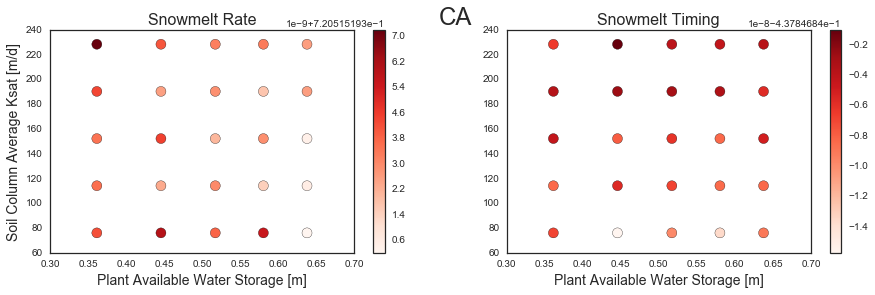

In [53]:
s = 100
cmap = 'Reds'
site = 'P301'
sitetitle = 'CA'
fig = plt.figure(figsize=(15,4))
x = 'Plant Available Water Storage [m]'
y = 'Soil Column Average Ksat [m/d]'
df = soils.loc[soils.Site == site]
vmin = -1
vmax = 1

fig.add_subplot(1,2,1)
c = 'multi_SMR_coef'
vmin,vmax = vminmax(df[c])


plt.scatter(x=df.PAWS,y = df.drainage, s= s, c=df[c],cmap=cmap)
plt.colorbar()
plt.title(c, fontsize=16)
plt.ylabel(y,fontsize=14)
plt.xlabel(x, fontsize=14)
plt.title('Snowmelt Rate', fontsize=16)

#fig.add_subplot(1,3,2)
#c = 'multi_PeakSWE_coef'
#vmin,vmax = vminmax(df[c])

#plt.scatter(x=df.PAWS,y = df.drainage, s= s, c=df[c],vmin=vmin,vmax=vmax,cmap=cmap)
#plt.colorbar()
#plt.title(c, fontsize=16)
#plt.xlabel(x, fontsize=14)
#plt.title('Snowmelt Amount', fontsize = 16)

fig.add_subplot(1,2,2)
c = 'multi_TpeakSWE_coef'
vmin,vmax = vminmax(df[c])

plt.scatter(x=df.PAWS,y = df.drainage, s= s, c=df[c],cmap=cmap)
plt.colorbar()
plt.title(c, fontsize=16)
plt.xlabel(x, fontsize=14)
plt.title('Snowmelt Timing', fontsize = 16)

plt.suptitle(sitetitle, fontsize= 24)

#plt.savefig('./figures/%s_%s_coef_comparison.png'%(sitetitle,exname),dpi=300, bbox_inches='tight')
#plt.savefig('./figures/%s_%s_coef_comparison.pdf'%(site,exname), bbox_inches='tight')

### Contour Plots

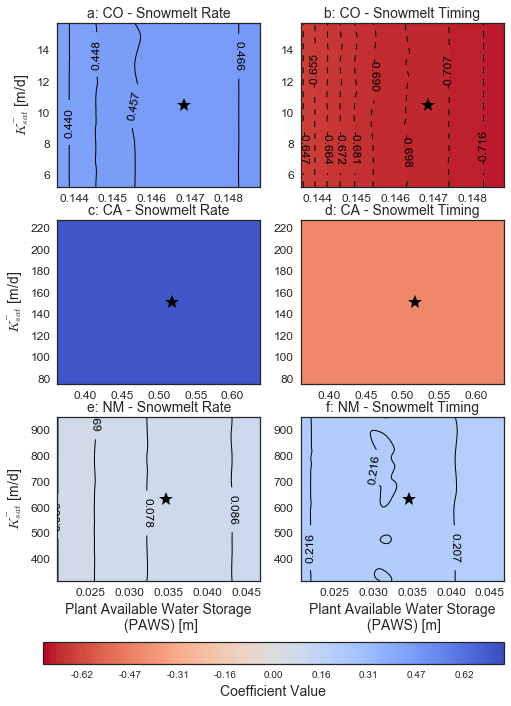

In [54]:
axfont = 12

fig = plt.figure(figsize=(8,10))
ax11 = fig.add_subplot(3,2,1)
ax12 = fig.add_subplot(3,2,2)
ax21 = fig.add_subplot(3,2,3)
ax22 = fig.add_subplot(3,2,4)
ax31 = fig.add_subplot(3,2,5)
ax32 = fig.add_subplot(3,2,6)

# Now adding the colorbar
cbaxes = fig.add_axes([0.1, 0.01, 0.8, 0.03]) 


npts = 100
ncts = 175
vmin = -0.75
vmax = 0.75
cmap = 'coolwarm_r'
x = 'Plant Available Water Storage\n (PAWS) [m]'
y = r'$\bar{K_{sat}}$ [m/d]'

contour_levels = np.linspace(vmin,vmax, ncts,endpoint=True)

for sitename,site,varname,c,ax,letter in zip(['CO','CO','CA','CA','NM','NM'],
    ['Nr1','Nr1','P301','P301','Vcm','Vcm'],
    ['Snowmelt Rate','Snowmelt Timing','Snowmelt Rate','Snowmelt Timing','Snowmelt Rate','Snowmelt Timing'],
    ['multi_SMR_coef','multi_TpeakSWE_coef','multi_SMR_coef','multi_TpeakSWE_coef','multi_SMR_coef','multi_TpeakSWE_coef'],
                                       [ax11,ax12,ax21,ax22,ax31,ax32],
                                            ['a','b','c','d','e','f']):
    
    sls = soils.loc[soils.Site == site] # subset the site
    
    xmid = sls.loc[sls.combo=='d3:s3','PAWS']
    ymid = sls.loc[sls.combo=='d3:s3','drainage']
    
    # set up the interpolation grid based on min and max of x and y axes
    ksat_max = sls.drainage.max()
    ksat_min = sls.drainage.min()

    storage_max = sls.PAWS.max()
    storage_min = sls.PAWS.min()

    xi = np.linspace(storage_min,storage_max,npts) # create the grid
    yi = np.linspace(ksat_min,ksat_max,npts)
    
    zi = griddata((sls.PAWS, sls.drainage), sls[c], (xi[None,:], yi[:,None]), method='cubic') # interpolate
    
    # plot and fill the contours
    Cl = ax.contour(xi,yi,zi,contour_levels,linewidths=1,ls='-',colors='k',vmin=vmin,vmax=vmax,levels=contour_levels)
    Cf = ax.contourf(xi,yi,zi,contour_levels,cmap=cmap,vmin=vmin,vmax=vmax,levels=contour_levels)
    ax.clabel(Cl)
    
    ax.set_title('%s: %s - %s'%(letter,sitename,varname), fontsize=axfont+2)
    [tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];
    [tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
    
    ax.plot(xmid,ymid,'*k',ms=15)
    
ax11.set_ylabel(y,fontsize=axfont+2);ax21.set_ylabel(y,fontsize=axfont+2);ax31.set_ylabel(y,fontsize=axfont+2)
ax31.set_xlabel(x,fontsize=axfont+2);ax32.set_xlabel(x,fontsize=axfont+2)
#cb = plt.colorbar(Cf)
cb = plt.colorbar(Cf,cax = cbaxes,orientation='horizontal',format='%0.2f') 
cb.set_label('Coefficient Value', fontsize=14)

#plt.savefig('./figures/soils_contour_plots.png',dpi=300,bbox_inches='tight')
#plt.savefig('./figures/soils_contour_plots.pdf',dpi=300)

In [62]:
soils.Site.uniquequeque()

array(['Nr1', 'P301', 'Vcm'], dtype=object)

In [66]:
soils.loc[soils.Site=='P301'].PAWS.describe().round(3)

count    25.000
mean      0.508
std       0.099
min       0.361
25%       0.446
50%       0.517
75%       0.580
max       0.638
Name: PAWS, dtype: float64

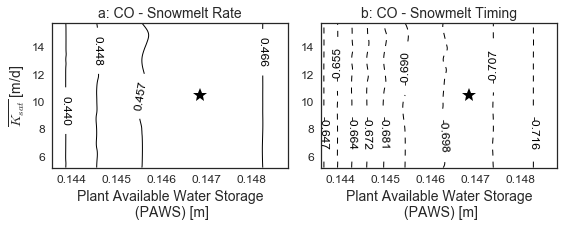

In [71]:
axfont = 12

fig = plt.figure(figsize=(8,5.5))
ax11 = fig.add_subplot(2,2,1)
ax12 = fig.add_subplot(2,2,2)

# Now adding the colorbar
#cbaxes = fig.add_axes([0.15, 0.3, 0.8, 0.1]) 

npts = 100
ncts = 175
vmin = -0.75
vmax = 0.75
#vmin = soils.multi_SMR_coef.max()*-1.
#vmax = soils.multi_SMR_coef.max()
#cmaps = ['red','blues']
x = 'Plant Available Water Storage\n (PAWS) [m]'
y = r'$\overline{K_{sat}}$ [m/d]'

contour_levels = np.linspace(vmin,vmax, ncts,endpoint=True)

for sitename,site,varname,c,ax,letter in zip(['CO','CO'],['Nr1','Nr1'],['Snowmelt Rate','Snowmelt Timing'],
    ['multi_SMR_coef','multi_TpeakSWE_coef'],[ax11,ax12],['a','b']):
    
    sls = soils.loc[soils.Site == site] # subset the site
    
    xmid = sls.loc[sls.combo=='d3:s3','PAWS']
    ymid = sls.loc[sls.combo=='d3:s3','drainage']
    
    # set up the interpolation grid based on min and max of x and y axes
    ksat_max = sls.drainage.max()
    ksat_min = sls.drainage.min()

    storage_max = sls.PAWS.max()
    storage_min = sls.PAWS.min()

    xi = np.linspace(storage_min,storage_max,npts) # create the grid
    yi = np.linspace(ksat_min,ksat_max,npts)
    
    zi = griddata((sls.PAWS, sls.drainage), sls[c], (xi[None,:], yi[:,None]), method='cubic') # interpolate
    
    # plot and fill the contours
    Cl = ax.contour(xi,yi,zi,contour_levels,linewidths=1,ls='-',colors='k',vmin=vmin,vmax=vmax,levels=contour_levels)
    #Cf = ax.contourf(xi,yi,zi,contour_levels,cmap=cmap,vmin=vmin,vmax=vmax,levels=contour_levels)
    ax.clabel(Cl)
    
    ax.set_title('%s: %s - %s'%(letter,sitename,varname), fontsize=axfont+2)
    [tick.label.set_fontsize(axfont) for tick in ax.yaxis.get_major_ticks()];
    [tick.label.set_fontsize(axfont) for tick in ax.xaxis.get_major_ticks()];
    
    ax.plot(xmid,ymid,'*k',ms=15)
    
ax11.set_ylabel(y,fontsize=axfont+2);
ax11.set_xlabel(x,fontsize=axfont+2);ax12.set_xlabel(x,fontsize=axfont+2)
#cb = plt.colorbar(Cf)
#cb = plt.colorbar(Cf,cax = cbaxes,orientation='horizontal',format='%0.2f') 
#cb.set_label('Coefficient Value', fontsize=14)
fig.tight_layout()

plt.savefig('./figures/soils_contour_plots_CO.png',dpi=300,bbox_inches='tight')
plt.savefig('./figures/soils_contour_plots_CO.pdf',dpi=300)

In [214]:
soils[['multi_SMR_coef','multi_TpeakSWE_coef']].describe()

multi_SMR_coef  multi_TpeakSWE_coef
count       75.000000            75.000000
mean         0.486594            -0.279119
std          0.266602             0.341425
min          0.088431            -0.637743
25%          0.129059            -0.577467
50%          0.615872            -0.437847
75%          0.720515             0.182572
max          0.720515             0.210681

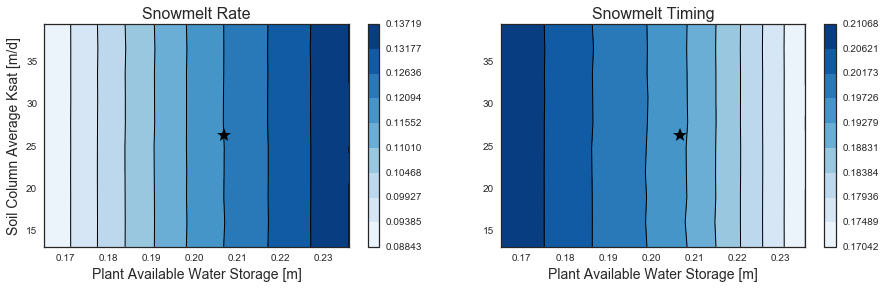

In [96]:
site = 'Vcm'

sls = soils.loc[soils.Site == site]

fig =xmid = sls.loc[sls.combo=='d3:s3','PAWS']
ymid = sls.loc[sls.combo=='d3:s3','drainage']
plt.figure(figsize=(15,4))
npts = 10
ncts = 10
cmap = 'coolwarm_r'

x = 'Plant Available Water Storage [m]'
y = 'Soil Column Average Ksat [m/d]'

# set up the interpolation grid based on min and max of x and y axes
ksat_max = sls.drainage.max()
ksat_min = sls.drainage.min()

storage_max = sls.PAWS.max()
storage_min = sls.PAWS.min()

xi = np.linspace(storage_min,storage_max,npts) # create the grid
yi = np.linspace(ksat_min,ksat_max,npts)

fig.add_subplot(1,2,1)
c = 'multi_SMR_coef'
zi = griddata((sls.PAWS, sls.drainage), sls[c], (xi[None,:], yi[:,None]), method='cubic') # interpolate
vmin = sls[c].min()
vmax = sls[c].max()
contour_levels = np.linspace(vmin,vmax, ncts,endpoint=True)
CS = plt.contour(xi,yi,zi,contour_levels,linewidths=1,ls='-',colors='k',vmin=vmin,vmax=vmax)
CS = plt.contourf(xi,yi,zi,contour_levels,cmap='Blues',vmin=vmin,vmax=vmax)
cb = plt.colorbar()
plt.plot(xmid,ymid,'*k',ms=15)
plt.title('Snowmelt Rate', fontsize=16)
plt.xlabel(x, fontsize=14)
plt.ylabel(y,fontsize=14)
cb.formatter.set_useOffset(False)
cb.update_ticks()

fig.add_subplot(1,2,2)
c = 'multi_TpeakSWE_coef'
zi = griddata((sls.PAWS, sls.drainage), sls[c], (xi[None,:], yi[:,None]), method='cubic')
vmin = sls[c].min()
vmax = sls[c].max()

if (vmin > 0) & (vmax > 0):
    cmap = 'Blues'
else:
        cmap = 'Reds_r'

contour_levels = np.linspace(vmin,vmax, ncts,endpoint=True)
CS = plt.contour(xi,yi,zi,contour_levels,linewidths=1,ls='-',colors='k',vmin=vmin,vmax=vmax)
CS = plt.contourf(xi,yi,zi,contour_levels,cmap=cmap,vmin=vmin,vmax=vmax)
plt.plot(xmid,ymid,'*k',ms=15)
cb = plt.colorbar()
plt.title('Snowmelt Timing', fontsize=16)
plt.xlabel(x, fontsize=14)
cb.formatter.set_useOffset(False)
cb.update_ticks()

#fig.add_subplot(1,3,3)
#c = 'PeakSWE_coef'
#zi = griddata((soils.PAWS, soils.drainage), soils[c], (xi[None,:], yi[:,None]), method='cubic')
#vmin,vmax = vminmax(zi)
#contour_levels = np.linspace(vmin, vmax, ncts,endpoint=True)
#CS = plt.contour(xi,yi,zi,contour_levels,linewidths=1,ls='-',colors='k')
#CS = plt.contourf(xi,yi,zi,contour_levels,cmap=cmap)
#plt.plot(xmid,ymid,'*k',ms=15)
#plt.colorbar()
#plt.title('Snowmelt Amount', fontsize=16)
#plt.xlabel(x, fontsize=14)

#plt.savefig('./figures/%s_%s_coef_comparison_contour.png'%(site,exname),dpi=300, bbox_inches='tight')
#plt.savefig('./figures/%s_%s_coef_comparison_contour.pdf'%(site,exname), bbox_inches='tight')

In [104]:
## Make Scatter plots of the calibrated run
data2 = data.loc[data.combo=='d3:s3'].copy()

In [108]:
data2['PeakSWE_2'] = np.square(data2.PeakSWE)

In [110]:
mod = sm.ols('RR_ET ~ PeakSWE + PeakSWE_2 + 1', data2).fit()

xs = np.linspace(data2.PeakSWE.min(),data2.PeakSWE.max(),100,endpoint=True)

In [111]:
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                  RR_ET   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     317.0
Date:                Tue, 06 Dec 2016   Prob (F-statistic):          3.29e-134
Time:                        19:39:32   Log-Likelihood:                 25768.
No. Observations:               10000   AIC:                        -5.153e+04
Df Residuals:                    9997   BIC:                        -5.151e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.9718      0.001   1641.781      0.0

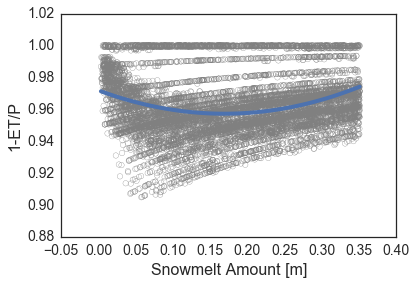

In [113]:
plt.figure(figsize=(6,4))
plt.scatter(data2.PeakSWE/1000.,data2.RR_ET,s=30,c='none',edgecolors='0.5')
plt.plot(xs/1000.,xs*mod.params['PeakSWE'] + xs**2*mod.params['PeakSWE_2'] + mod.params['Intercept'],lw=4)
plt.ylabel('1-ET/P', fontsize=16)
plt.xlabel('Snowmelt Amount [m]', fontsize=16)
ax = plt.gca()
[tick.label.set_fontsize(14) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(14) for tick in ax.yaxis.get_major_ticks()];
#plt.axvline(0.4,c='0.6')
#plt.ylim(0.9,1)
#plt.savefig('./figures/peak_swe_RR_ET_ex.png', dpi=300, bbox_inches='tight')

In [86]:
data2.RR_ET.describe()

count    10000.000000
mean         0.935444
std          0.005535
min          0.923864
25%          0.931686
50%          0.934679
75%          0.938747
max          0.959128
Name: RR_ET, dtype: float64

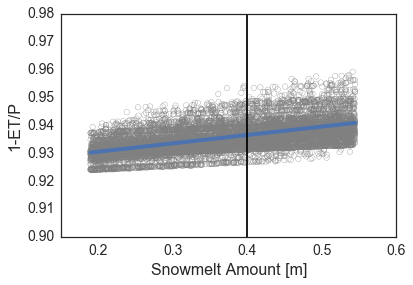

In [103]:
plt.figure(figsize=(6,4))
plt.scatter(data2.PeakSWE/1000.,data2.RR_ET,s=30,c='none',edgecolors='0.5')
plt.plot(xs/1000.,xs*mod.params['PeakSWE'] +mod.params['Intercept'],lw=4)
plt.ylabel('1-ET/P', fontsize=16)
plt.xlabel('Snowmelt Amount [m]', fontsize=16)
ax = plt.gca()
[tick.label.set_fontsize(14) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(14) for tick in ax.yaxis.get_major_ticks()];
plt.axvline(0.4,c='k')
#plt.ylim(0.9,1)
plt.savefig('./figures/peak_swe_RR_ET_ex_vert.png', dpi=300, bbox_inches='tight')

#### data2.columns

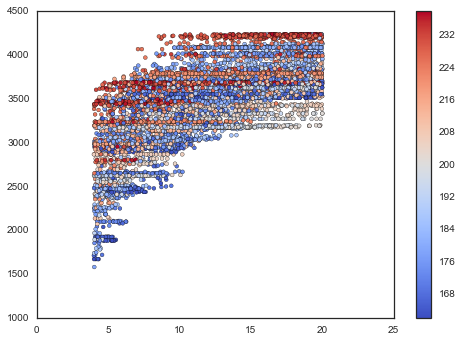

In [104]:
plt.scatter(data2.SMR,data2.gwStore,s=15,c=data2.TpeakSWE,cmap='coolwarm')
plt.colorbar()

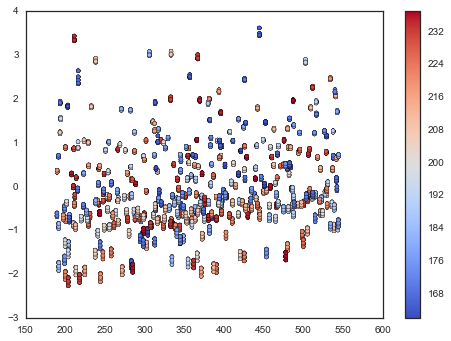

In [246]:
plt.scatter(data2.PeakSWE,data2.RR_ET2,s=15,c=data2.TpeakSWE,cmap='coolwarm')
plt.colorbar()

In [230]:
data.loc[data.combo=='d3:s3'].shape

(10000, 47)

### Compare each Site

In [113]:
tmp = pd.read_pickle('./data/Nr1_soils_coef_smex7_sen_full.pcl')
tmp['Site'] = 'Nr1'

tmp2 = pd.read_pickle('./data/Vcm_soils_coef_smex7_sen_full2.pcl')
tmp2['Site'] = 'Vcm'

tmp3 = pd.read_pickle('./data/p301_soils_coef_smex7_sen_full.pcl')
tmp3['Site'] = 'P301'

full = pd.concat([tmp,tmp2,tmp3],axis=0)
full = full[['SMR_coef','TpeakSWE_coef','PeakSWE_coef','combo','Site']]
full = full.loc[full.combo=='d3:s3'].copy()
del full['combo']
full2 = pd.melt(full,id_vars=['Site'])

In [106]:
def set_varID(var):
    if var=='SMR_coef':
        return 1
    if var=='TpeakSWE_coef':
        return 2
    if var=='PeakSWE_coef':
        return 3

In [115]:
full2['varID'] = full2.variable.map(set_varID)

In [108]:
tmp = pd.read_pickle('./data/Nr1_soils_coef_smex7_sen_melt.pcl')
tmp['Site'] = 'Nr1'

tmp2 = pd.read_pickle('./data/Vcm_soils_coef_smex7_sen_melt.pcl')
tmp2['Site'] = 'Vcm'

tmp3 = pd.read_pickle('./data/p301_soils_coef_smex7_sen_melt.pcl')
tmp3['Site'] = 'P301'

melt = pd.concat([tmp,tmp2,tmp3],axis=0)
melt = melt[['SMR_coef','TpeakSWE_coef','PeakSWE_coef','combo','Site']]
#melt = melt.loc[melt.combo=='d3:s3'].copy()
#del melt['combo']
melt2 = pd.melt(melt,id_vars=['Site','combo'])
#melt2['varID'] = [1,1,1,2,2,2,3,3,3]

In [109]:
melt2['varID'] = melt2.variable.map(set_varID)

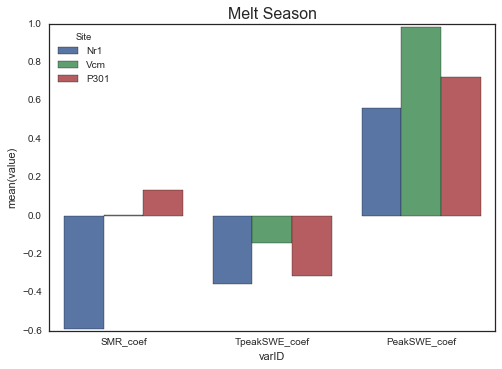

In [116]:
p = sns.barplot(x='varID', y='value',data=full2,hue='Site')
p.set_xticklabels(melt2.variable.unique())
plt.title('Melt Season', fontsize = 16)

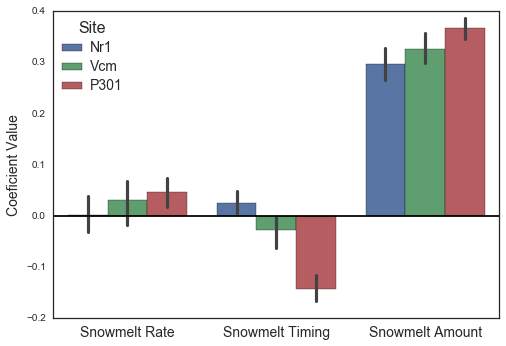

In [106]:
p = sns.barplot(x='varID', y='value',data=melt2,hue='Site',ci = 100)
p.set_xticklabels(['Snowmelt Rate','Snowmelt Timing','Snowmelt Amount'], fontsize=14)
p.set_xlabel('')
p.set_ylabel('Coeficient Value', fontsize=14)
l = plt.legend(loc='upper left')
l.set_title('Site')
ltext = l.get_texts()
ltitle = l.get_title()
plt.setp(ltext, fontsize=14)
plt.setp(ltitle, fontsize = 16)
plt.axhline(0,c='k')

plt.savefig('./figures/%s_coeficient_comparison.png'%exname,dpi=300,bbox_inches='tight')
plt.savefig('./figures/%s_coeficient_comparison.pdf'%exname,bbox_inches='tight')

In [205]:
# clean the data frame to so that in only contains the calibrated coef and the min and max for each variable

sites = []
variables = []
values = []
varids = []
for site in full2.Site.unique():
    for var,varid in zip(full2.variable.unique(),full2.varID.unique()):
        
        sites.append(site)
        variables.append(var)
        varids.append(varid)
        values.append(full2.loc[(full2.variable==var) & (full2.Site==site),'value'].max())
        
        sites.append(site)
        variables.append(var)
        varids.append(varid)
        values.append(full2.loc[(full2.variable==var) & (full2.Site==site),'value'].min())
        
        sites.append(site)
        variables.append(var)
        varids.append(varid)
        values.append(full2.loc[(full2.variable==var) & (full2.Site==site) & (full2.combo == 'd3:s3'),'value'].as_matrix()[0])
        
full3 = pd.DataFrame({'Site':sites,'value':values,'variable':variables,'varID':varids})

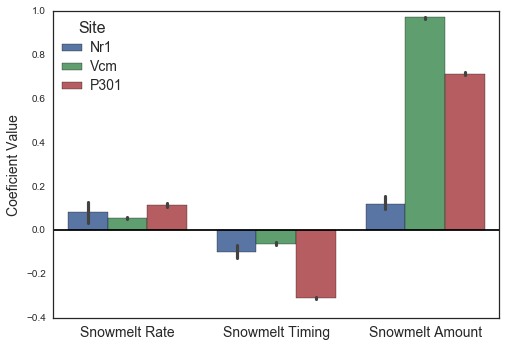

In [214]:
p = sns.barplot(x='varID', y='value',data=full2,hue='Site',ci = 100,estimator=np.median)
p.set_xticklabels(['Snowmelt Rate','Snowmelt Timing','Snowmelt Amount'], fontsize=14)
p.set_xlabel('')
p.set_ylabel('Coeficient Value', fontsize=14)
l = plt.legend(loc='upper left')
l.set_title('Site')
ltext = l.get_texts()
ltitle = l.get_title()
plt.setp(ltext, fontsize=14)
plt.setp(ltitle, fontsize = 16)
plt.axhline(0,c='k')

plt.savefig('./figures/%s_coeficient_comparison.png'%exname,dpi=300,bbox_inches='tight')
plt.savefig('./figures/%s_coeficient_comparison.pdf'%exname,bbox_inches='tight')

In [213]:
np.median([0.227485,-0.025342,0.080518])

0.080518000000000006

In [239]:
y = 'RR'
x = 'SMR'
c = 'TPeakSWE'
print sm.ols('%s ~ %s + 1'%(y,x),data).fit().summary()

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                 3.370e+04
Date:                Tue, 15 Nov 2016   Prob (F-statistic):               0.00
Time:                        09:59:59   Log-Likelihood:             2.2064e+05
No. Observations:               50000   AIC:                        -4.413e+05
Df Residuals:                   49998   BIC:                        -4.413e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0227    3.7e-05    613.953      0.0

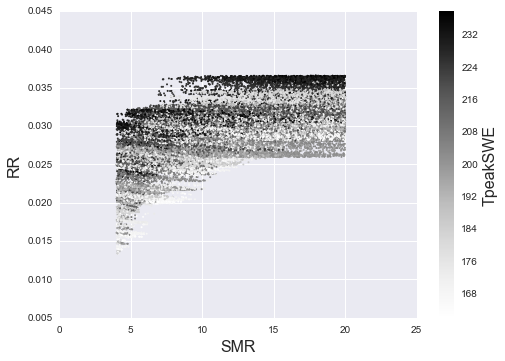

In [240]:
plt.scatter(data[x],data[y],s=4,c=data[c],edgecolors='none')
cb = plt.colorbar()
plt.xlabel(x, fontsize=16)
plt.ylabel(y, fontsize=16)
cb.set_label(c, fontsize=16)

In [241]:
data['closure'] = data.Pex - (data.ET + data.Q)

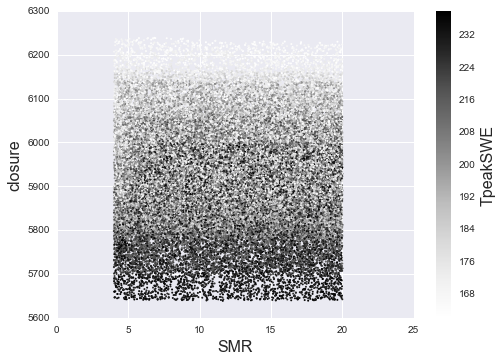

In [242]:
y = 'closure'
x = 'SMR'
c = 'TPeakSWE'
plt.scatter(data[x],data[y],s=4,c=data[c],edgecolors='none')
cb = plt.colorbar()
plt.xlabel(x, fontsize=16)
plt.ylabel(y, fontsize=16)
cb.set_label(c, fontsize=16)

In [243]:
y = 'RR_ET'
x = 'SMR'
c = 'TPeakSWE'
print sm.ols('%s ~ %s + 1'%(y,x),data).fit().summary()

                            OLS Regression Results                            
Dep. Variable:                  RR_ET   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                 2.669e+04
Date:                Tue, 15 Nov 2016   Prob (F-statistic):               0.00
Time:                        10:00:32   Log-Likelihood:             1.9914e+05
No. Observations:               50000   AIC:                        -3.983e+05
Df Residuals:                   49998   BIC:                        -3.983e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.9442   5.69e-05   1.66e+04      0.0

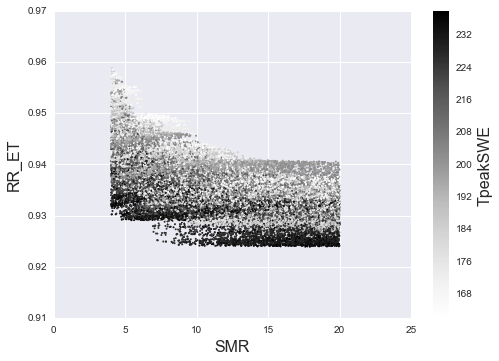

In [244]:
plt.scatter(data[x],data[y],s=4,c=data[c],edgecolors='none')
cb = plt.colorbar()
plt.xlabel(x, fontsize=16)
plt.ylabel(y, fontsize=16)
cb.set_label(c, fontsize=16)

In [245]:
y = 'gwStore'
x = 'SMR'
c = 'TPeakSWE'
print sm.ols('%s ~ %s + 1'%(y,x),data).fit().summary()

                            OLS Regression Results                            
Dep. Variable:                gwStore   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                 4.649e+04
Date:                Tue, 15 Nov 2016   Prob (F-statistic):               0.00
Time:                        10:04:06   Log-Likelihood:            -3.5928e+05
No. Observations:               50000   AIC:                         7.186e+05
Df Residuals:                   49998   BIC:                         7.186e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2656.6452      4.034    658.516      0.0

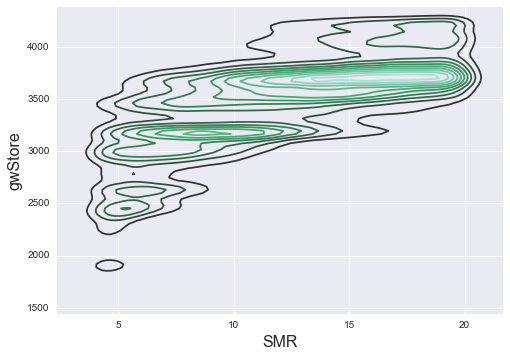

In [246]:
sns.kdeplot(data[x],data2=data[y])
#plt.scatter(data[x],data[y],s=4,c=data[c],edgecolors='none')
#cb = plt.colorbar()
plt.xlabel(x, fontsize=16)
plt.ylabel(y, fontsize=16)
cb.set_label(c, fontsize=16)

In [247]:
y = 'gwFlux'
x = 'SMR'
c = 'TPeakSWE'
print sm.ols('%s ~ %s + 1'%(y,x),data).fit().summary()

                            OLS Regression Results                            
Dep. Variable:                 gwFlux   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                 4.649e+04
Date:                Tue, 15 Nov 2016   Prob (F-statistic):               0.00
Time:                        10:04:35   Log-Likelihood:                 80843.
No. Observations:               50000   AIC:                        -1.617e+05
Df Residuals:                   49998   BIC:                        -1.617e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.3995      0.001    658.638      0.0

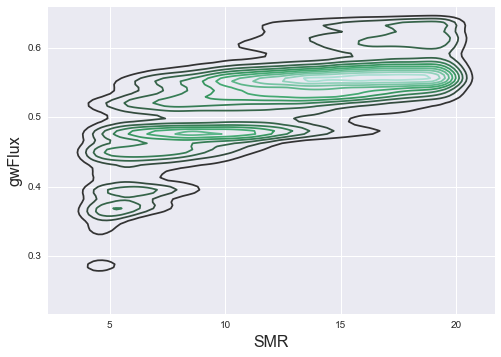

In [248]:
sns.kdeplot(data[x],data2=data[y])
#plt.scatter(data[x],data[y],s=4,c=data[c],edgecolors='none')
#cb = plt.colorbar()
plt.xlabel(x, fontsize=16)
plt.ylabel(y, fontsize=16)
cb.set_label(c, fontsize=16)

In [211]:
np.arange(5000,50000,500).shape

(90,)

In [197]:
r2 = []
error = []
p = []
scenarios = []
for i in np.arange(500,50000,500):
    
    r2tmp = []
    ptmp = []
    for o in np.arange(0,200):
    
        mod1 = sm.ols('ablRR_ET2 ~ TPeakSWE2+ SMR2 + PeakSWE2 + 1',data.iloc[np.random.randint(0,high=49999,size=i)]).fit()
        r2tmp.append(mod1.rsquared)
        ptmp.append(mod1.f_pvalue)
        
    r2.append(np.mean(r2tmp))
    p.append(np.mean(ptmp))
    error.append(np.std(r2tmp))
    scenarios.append(i)

(0.4, 0.8)

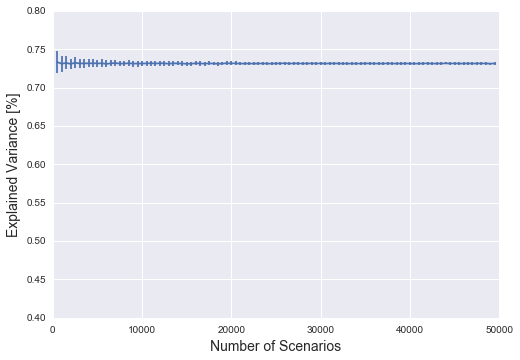

In [198]:
plt.errorbar(scenarios,r2,yerr=error)
plt.ylabel('Explained Variance [%]', fontsize = 14)
plt.xlabel('Number of Scenarios', fontsize = 14)
plt.ylim(0.4,0.8)

In [ ]:
mod1.rsquared

In [250]:
mod1 = sm.ols('RR2 ~ TPeakSWE2+ SMR2 + PeakSWE2 + 1',data).fit()
print mod1.summary()

                            OLS Regression Results                            
Dep. Variable:                    RR2   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                 5.309e+04
Date:                Tue, 15 Nov 2016   Prob (F-statistic):               0.00
Time:                        10:05:39   Log-Likelihood:                -35157.
No. Observations:               50000   AIC:                         7.032e+04
Df Residuals:                   49996   BIC:                         7.036e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   6.284e-16      0.002   2.87e-13      1.0

In [175]:
y = 'RR_ET'
x = 'PeakSWE'
print sm.ols('%s ~ %s + 1'%(y,x),data).fit().summary()

                            OLS Regression Results                            
Dep. Variable:                  RR_ET   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     5832.
Date:                Fri, 11 Nov 2016   Prob (F-statistic):               0.00
Time:                        15:04:24   Log-Likelihood:             1.8832e+05
No. Observations:               50000   AIC:                        -3.766e+05
Df Residuals:                   49998   BIC:                        -3.766e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0006   9.28e-05   1.08e+04      0.0

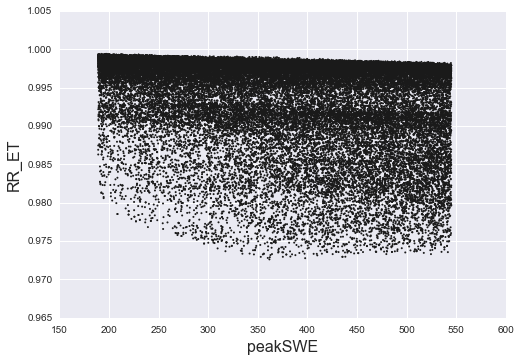

In [176]:
plt.scatter(data[x],data[y],s=4,edgecolors='none',c='0.1')
plt.xlabel(x, fontsize=16)
plt.ylabel(y, fontsize=16)

In [134]:
clf = tree.DecisionTreeRegressor(presort=True, max_depth=3)
fit = clf.fit(X=data[['SMR','TPeakSWE','PeakSWE']].as_matrix(),y=data['RR_ET'].as_matrix())

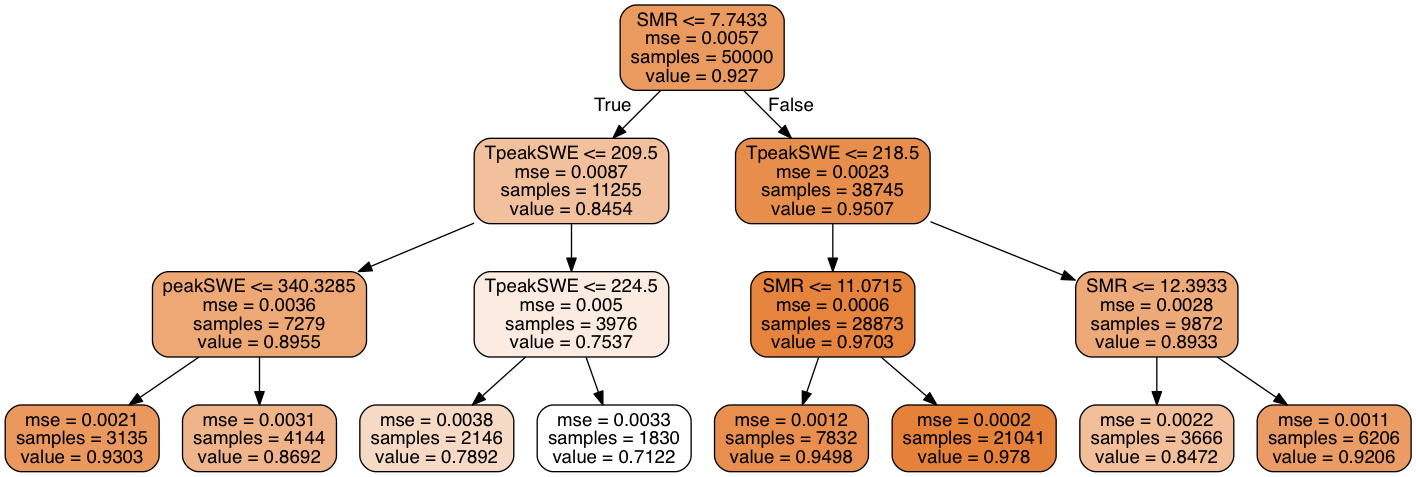

In [117]:
dot_data = tree.export_graphviz(fit, out_file=None,feature_names=['SMR','TPeakSWE','PeakSWE'], filled=True, rounded=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

In [7]:
niwot = pd.read_pickle('../data/niwot_stats.pcl')

## Calculate some Color Metrics

In [8]:
data['Color'] = 'b'
data.loc[(data.SMR>190) & (data.RR>0.2),'Color'] = 'g'
data.loc[(data.SMR>150) & (data.RR<0.1),'Color'] = 'r' 

In [9]:
data['ASL'] = data.Tnosnow-data.TPeakSWE

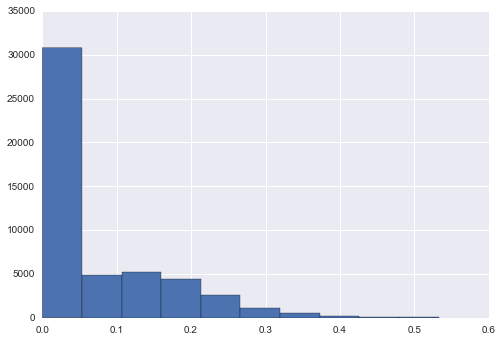

In [10]:
data.ablRR.hist()

In [11]:
data.describe()

SMR      TpeakSWE       peakSWE       ablSeas       Tnosnow  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean      12.080514    199.718280    365.677043     36.637440    236.355720   
std        4.575329     21.866204    102.470258     19.983106     29.005448   
min        4.000099    162.000000    189.004683     10.000000    173.000000   
25%        8.121388    181.000000    277.275595     22.000000    214.000000   
50%       12.085537    200.000000    364.916011     31.000000    236.000000   
75%       16.031637    219.000000    453.806439     46.000000    256.000000   
max       19.999785    238.000000    544.999312    133.000000    318.000000   

           ref     DOAS           idx           MAP            ET  \
count  50000.0  50000.0  50000.000000  50000.000000  50000.000000   
mean    2010.0     15.0  24999.500000    237.865390     40.782837   
std        0.0      0.0  14433.901067     76.380473     38.323290   
min     2010.0     15.0      0.000000     35.164315      3.920297   
25%     2010.0     15.0  12499.750000    173.164315     12.691004   
50%     2010.0     15.0  24999.500000    221.234875     22.491824   
75%     2010.0     15.0  37499.250000    292.656550     59.019916   
max     2010.0     15.0  49999.000000    426.476604    173.653103   

           ...       unsat_drainage       sat_def  sat_def_z            sm  \
count      ...              50000.0  5.000000e+04    50000.0  50000.000000   
mean       ...                  0.0  5.478913e+03    11441.0     88.227309   
std        ...                  0.0  4.984104e-09        0.0     98.581263   
min        ...                  0.0  5.478913e+03    11441.0      0.000000   
25%        ...                  0.0  5.478913e+03    11441.0      0.000000   
50%        ...                  0.0  5.478913e+03    11441.0     25.724324   
75%        ...                  0.0  5.478913e+03    11441.0    187.909005   
max        ...                  0.0  5.478913e+03    11441.0    259.412264   

             Pmodel           Pex            wb            RR         ablRR  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean     368.554278    603.542434    537.374129      0.047113      0.068366   
std      102.561476    107.705146    145.530740      0.065215      0.092973   
min      189.004683    320.961788     79.287647      0.000011      0.000021   
25%      279.996122    524.400944    439.766626      0.000184      0.000350   
50%      367.683290    601.662892    544.206016      0.008174      0.014427   
75%      456.767062    678.469202    641.312375      0.085488      0.125146   
max      568.930383    903.637398    891.335753      0.321393      0.532591   

                ASL  
count  50000.000000  
mean      36.637440  
std       19.983106  
min       10.000000  
25%       22.000000  
50%       31.000000  
75%       46.000000  
max      133.000000  

[8 rows x 29 columns]

In [12]:
data['Color'] = 'green'

In [13]:
tmp = sk.preprocessing.MinMaxScaler(data.SMR)

In [58]:
clf = tree.DecisionTreeRegressor(presort=True, max_depth=3)
scs = sk.model_selection.cross_val_score(clf,X=data[['SMR','TPeakSWE','PeakSWE']].as_matrix(),y=data['RR_ET'].as_matrix() ,cv=100, scoring='r2')

In [59]:
scs.mean()

0.58374495376777102

In [60]:
scs.std()

0.042017289428072598

In [62]:
fit = clf.fit(X=data[['SMR','TPeakSWE','PeakSWE']].as_matrix(),y=data['RR'].as_matrix())

In [48]:
fit.n_features_

3

In [18]:
cv = 100
scores = []
se = []
leafs = []
for k in np.arange(5,56):
    clf = tree.DecisionTreeRegressor(max_leaf_nodes=k,presort=True)
    scs = sk.model_selection.cross_val_score(clf,X=data[['SMR','TPeakSWE','PeakSWE']].as_matrix(),y=data['RR'].as_matrix() ,cv=cv)
    scores.append(np.mean(scs))
    se.append(np.std(scs))   
    leafs.append(k)
    print k

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


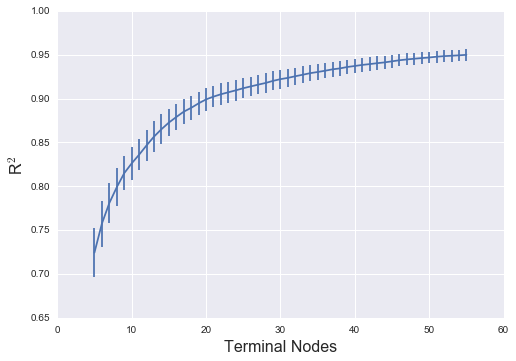

In [19]:
plt.errorbar(leafs,scores,yerr=se)
plt.xlabel('Terminal Nodes', fontsize=16)
plt.ylabel('R$^2$', fontsize=16)

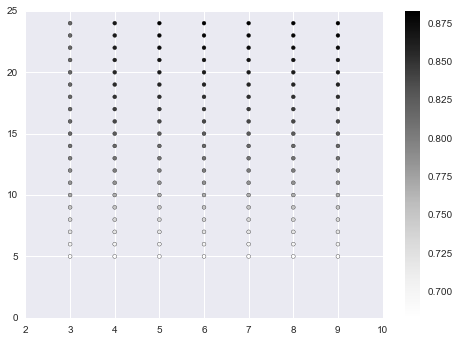

In [109]:
plt.scatter(depths,leafs,s=15,c=scores)
plt.colorbar()

In [83]:
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(data[['SMR','TPeakSWE','PeakSWE']].as_matrix(),)

In [101]:
sk.model_selection.cross_val_score(clf,X=data[['SMR','TPeakSWE','PeakSWE']].as_matrix(),y=data['RR'].as_matrix() ,cv=5)

array([ 0.73441659,  0.72181378,  0.7186479 ,  0.72246722,  0.7301388 ])

In [84]:
clf.score(data[['SMR','TPeakSWE','PeakSWE']].as_matrix(),data['RR'].as_matrix())

0.7284914417009809

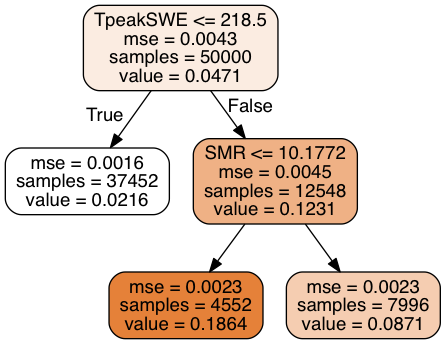

In [63]:
dot_data = tree.export_graphviz(fit, out_file=None,feature_names=['SMR','TPeakSWE','PeakSWE'], filled=True, rounded=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

In [ ]:
sm.

In [38]:
clf.

{'criterion': 'mse',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': 5,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [23]:
data.columns

Index([u'SMR', u'TpeakSWE', u'peakSWE', u'ablSeas', u'Tnosnow', u'ref',
       u'date_ONS', u'DOAS', u'date_AS', u'idx', u'date_peakSWE', u'MAP',
       u'ET', u'Q', u'Qbf', u'Qrf', u'rech', u'sat', u'p', u'rz_storage',
       u'rz_drainage', u'unsat_storage', u'unsat_drainage', u'sat_def',
       u'sat_def_z', u'Pmodel', u'Pex', u'wb', u'RR', u'ablRR', u'Color',
       u'ASL'],
      dtype='object')

In [24]:
norm = mpl.colors.Normalize(vmin=data.ASL.min(), vmax=data.ASL.max())
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)

In [25]:
tmp = []
for days in data.ASL:
    tmp.append(m.to_rgba(days))

In [26]:
data.Qbf.describe()

count    50000.000000
mean        17.689556
std         25.044528
min          0.040581
25%          0.098495
50%          4.420902
75%         31.569139
max         93.865474
Name: Qbf, dtype: float64

In [16]:
onethird = np.percentile(data.SMR,33.3)

In [17]:
twothird = np.percentile(data.SMR,66.6)

In [18]:
def define_percentile(dat):

    if dat <= onethird:
        return 1
    elif (dat > onethird) & (dat <= twothird):
        return 2
    else:
        return 3

In [19]:
data['SMR_tercile'] = data.SMR.map(define_percentile)

In [20]:
onethird =  np.percentile(data.TPeakSWE,33.3)

In [21]:
twothird =  np.percentile(data.TPeakSWE,66.6)

In [63]:
def define_percentile(dat):

    if dat <= onethird:
        return 1
    elif (dat > onethird) & (dat <= twothird):
        return 2
    else:
        return 3

In [23]:
data['TPeakSWE_tercile'] = data.TPeakSWE.map(define_percentile)

In [62]:
onethird =  np.percentile(data.PeakSWE,33.3)
twothird =  np.percentile(data.PeakSWE,66.6)

In [64]:
data['PeakSWE_tercile'] = data.PeakSWE.map(define_percentile)

In [53]:
minima = data.PeakSWE.min()
maxima = data.PeakSWE.max()

norm = matplotlib.colors.Normalize(vmin=minima,vmax=maxima,clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)

colors = []
for val in data.PeakSWE:
    colors.append(mapper.to_rgba(val))

In [50]:
mapper.to_rgba(40.3)

(0.93787005368401022, 0.96462899095871868, 0.99015763226677389, 1.0)

In [68]:
plt.figure(figsize=(20,15))
grid = sns.FacetGrid(data,col='PeakSWE_tercile',row='TPeakSWE_tercile',sharex=False,sharey=False)
grid.map(sns.kdeplot,'SMR','RR')

KeyError: 'TpeakSWE_tercile'

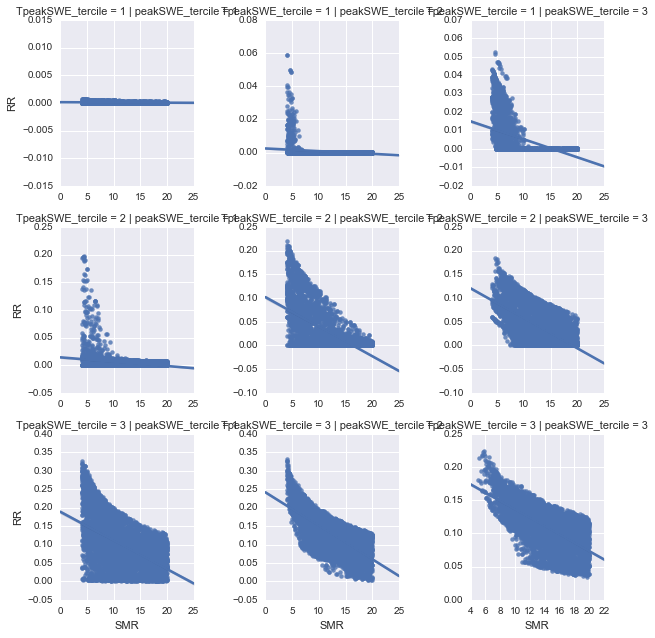

In [76]:
grid = sns.FacetGrid(data,col='PeakSWE_tercile',row='TPeakSWE_tercile',sharex=False,sharey=False)
grid.map(sns.regplot, 'SMR','RR')

KeyboardInterrupt: 

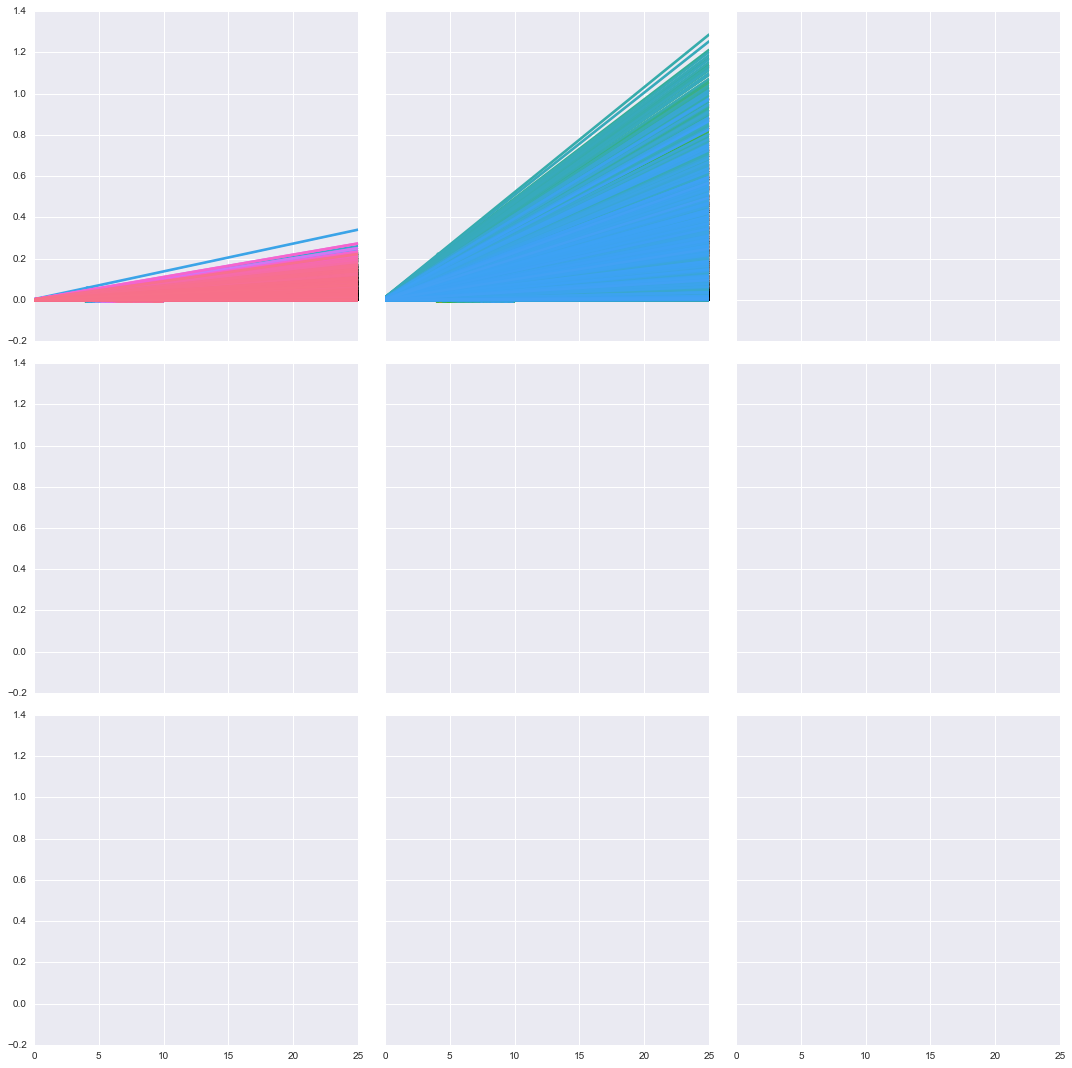

In [47]:
sns.lmplot('SMR','RR',data,hue='PeakSWE',col='TPeakSWE_tercile',row='SMR_tercile')

In [41]:
data.TPeakSWE_tercile.describe()

count    50000.000000
mean         1.994960
std          0.814756
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: TpeakSWE_tercile, dtype: float64

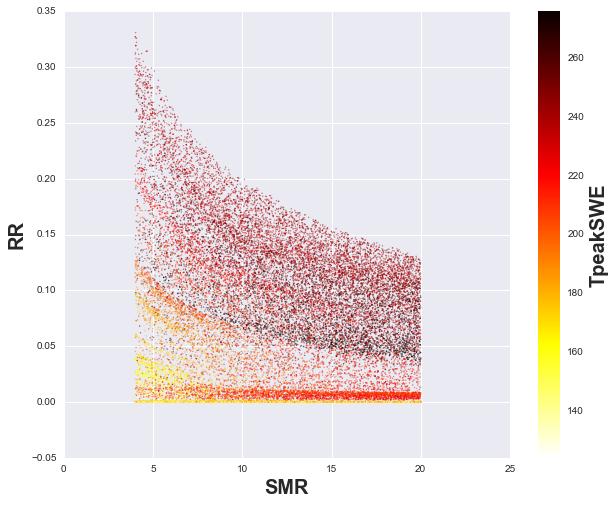

In [7]:
plt.figure(figsize=(10,8))
ykey = 'RR'
xkey = 'SMR'
ckey = 'TPeakSWE'
plt.scatter(data[xkey],data[ykey],s = 2, c = data[ckey],cmap='hot_r',edgecolor='none', alpha=0.5);
c = plt.colorbar();
c.set_label(ckey, fontsize = 20, weight = 'bold')
plt.xlabel(xkey,fontsize=20,weight='bold')
plt.ylabel(ykey, fontsize=20,weight='bold')
#plt.ylim(0,1.1)
c.alpha=1
c.draw_all()
#plt.savefig('./figures/RR_ARD_SMR.png', dpi=300,bbox_inches='tight')

In [26]:
data.columns

Index([u'Tnosnow', u'TpeakSWE', u'peakSWE', u'SMR', u'ref', u'date_ONS',
       u'DOAS', u'date_AS', u'idx', u'date_peakSWE', u'MAP', u'ET', u'Q',
       u'Qbf', u'Qrf', u'rech', u'sat', u'p', u'rz_storage', u'rz_drainage',
       u'unsat_storage', u'unsat_drainage', u'sat_def', u'sat_def_z',
       u'Pmodel', u'Pex', u'wb', u'RR', u'ablRR', u'Color', u'ASL'],
      dtype='object')

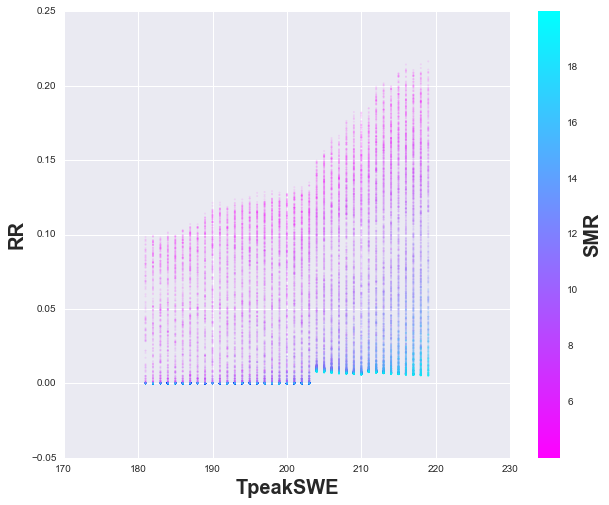

In [62]:
plt.figure(figsize=(10,8))
ykey = 'RR'
xkey = 'TPeakSWE'
ckey = 'SMR'
plt.scatter(data[xkey],data[ykey],s = 4, c = data[ckey],cmap='cool_r',edgecolor='none',alpha = 0.1);
c = plt.colorbar();
c.set_label(ckey, fontsize = 20, weight = 'bold')
plt.xlabel(xkey,fontsize=20,weight='bold')
plt.ylabel(ykey, fontsize=20,weight='bold')
#plt.ylim(0.4,1.1)
c.alpha=1
c.draw_all()
#plt.savefig('./figures/smex2_RR_SMR_DOWPeakSWE.png', dpi=300,bbox_inches='tight')

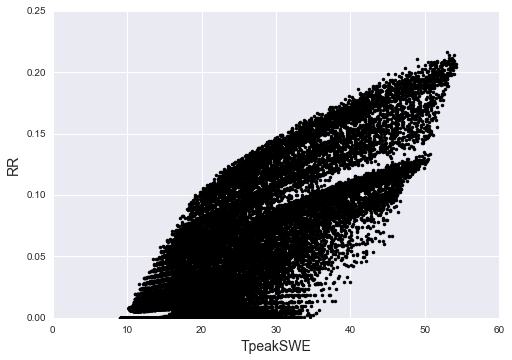

In [75]:
xkey = 'TPeakSWE/SMR'
ykey = 'RR'
plt.plot(data.TPeakSWE/data.SMR,data[ykey],'.k')
plt.xlabel(xkey,fontsize = 14)
plt.ylabel(ykey,fontsize = 14)

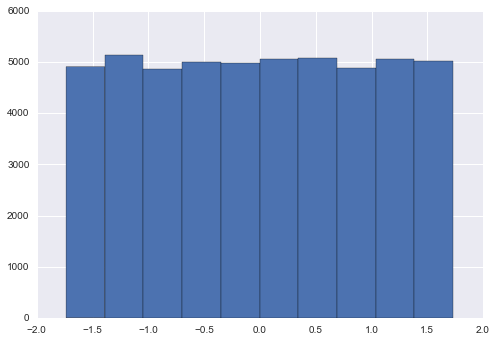

In [40]:
data.SMR2.hist()

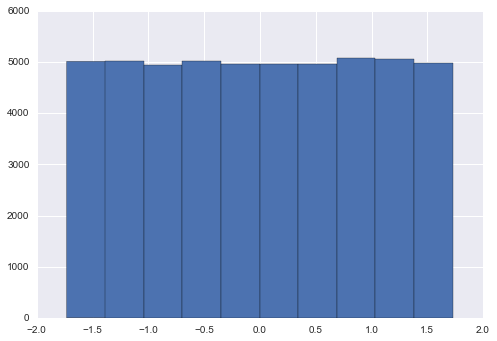

In [41]:
data.PeakSWE2.hist()

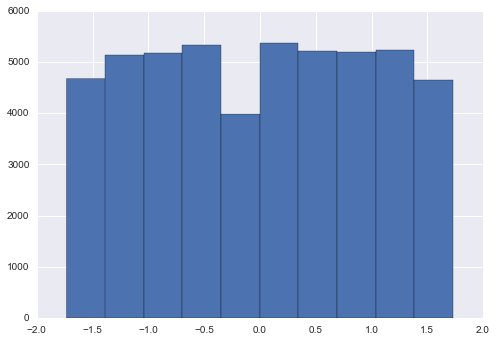

In [42]:
data.TPeakSWE2.hist()

In [67]:
print sm.ols('RR2 ~ SMR2 + 1',data).fit().summary()

mod1 = sm.ols('RR2 ~ TPeakSWE2+ SMR2 + PeakSWE2 + 1',data).fit()
print mod1.summary()

                            OLS Regression Results                            
Dep. Variable:                    RR2   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                 1.175e+04
Date:                Wed, 09 Nov 2016   Prob (F-statistic):               0.00
Time:                        16:49:16   Log-Likelihood:                -65670.
No. Observations:               50000   AIC:                         1.313e+05
Df Residuals:                   49998   BIC:                         1.314e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   7.524e-17      0.004   1.87e-14      1.0

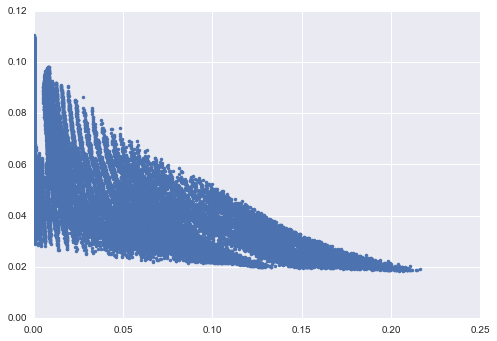

In [32]:
plt.plot(data.RR,data.SMR_TPeakSWE,'.')

In [33]:
mod2 = sm.ols('RR2 ~ SMR_TPeakSWE2 + 1',data).fit()
print mod2.summary()

                            OLS Regression Results                            
Dep. Variable:                    RR2   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                 5.602e+04
Date:                Fri, 04 Nov 2016   Prob (F-statistic):               0.00
Time:                        14:33:10   Log-Likelihood:                -52157.
No. Observations:               50000   AIC:                         1.043e+05
Df Residuals:                   49998   BIC:                         1.043e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      1.366e-16      0.003   4.45e-14

In [66]:
data.columns

Index([u'SMR', u'TpeakSWE', u'peakSWE', u'ablSeas', u'Tnosnow', u'ref',
       u'date_ONS', u'DOAS', u'date_AS', u'idx', u'date_peakSWE', u'MAP',
       u'ET', u'Q', u'Qbf', u'Qrf', u'rech', u'sat', u'p', u'rz_storage',
       u'rz_drainage', u'unsat_storage', u'unsat_drainage', u'sat_def',
       u'sat_def_z', u'Pmodel', u'Pex', u'wb', u'RR', u'ablRR'],
      dtype='object')

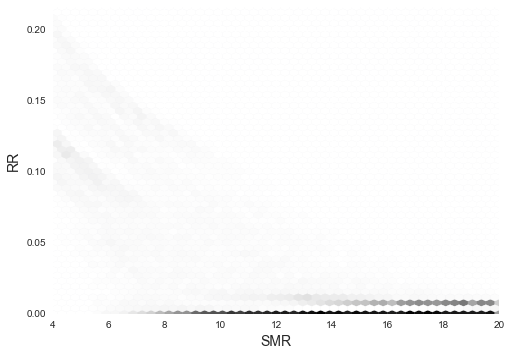

In [71]:
xkey = 'SMR'
ykey = 'RR'
plt.hexbin(data[xkey],data[ykey],gridsize=50)
plt.xlabel(xkey,fontsize = 14)
plt.ylabel(ykey,fontsize = 14)

In [17]:
import time
from IPython.display import clear_output
import matplotlib.animation as animation

In [18]:
data.TPeakSWE.max()

219.0

(0, 0.6)

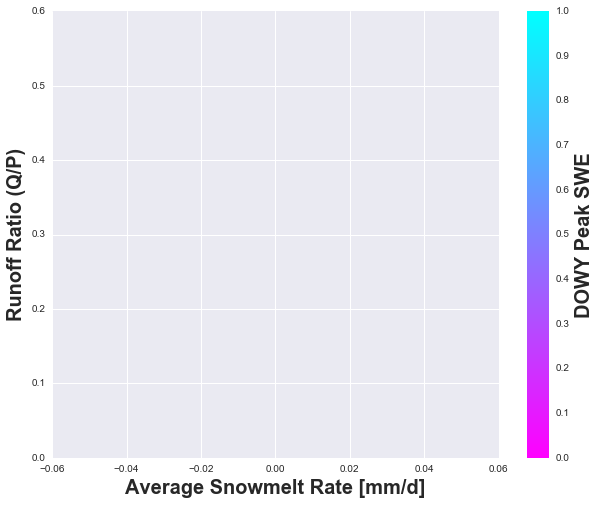

In [19]:
plt.figure(figsize=(10,8))
tmp = data.loc[(data.TPeakSWE >= 172) & (data.TPeakSWE<=174)]
ykey = 'RR'
xkey = 'SMR'

p = plt.scatter(tmp[xkey],tmp[ykey],s = 2, c = tmp.TPeakSWE,cmap='cool_r',edgecolor='none',alpha = 1);
c = plt.colorbar()
c.set_label('DOWY Peak SWE', fontsize = 20, weight = 'bold')
plt.xlabel('Average Snowmelt Rate [mm/d]',fontsize=20,weight='bold')
plt.ylabel('Runoff Ratio (Q/P)', fontsize=20,weight='bold')
plt.ylim(0,0.6)
#plt.savefig('./figures/smex2_RR_SMR_DOWPeakSWE_d4.png', dpi=300,bbox_inches='tight')

In [15]:
tmp = data.loc[(data.RR>0.29) & (data.RR<0.31) & (data.SMR >6.) & (data.SMR <8.)]

In [180]:
len(tmp)

1547

In [17]:
data.columns

Index([u'Tnosnow', u'TpeakSWE', u'peakSWE', u'SMR', u'ref', u'date_ONS',
       u'DOAS', u'date_AS', u'idx', u'date_peakSWE', u'MAP', u'ET', u'Q',
       u'Qbf', u'Qrf', u'rech', u'sat', u'p', u'rz_storage', u'rz_drainage',
       u'unsat_storage', u'unsat_drainage', u'sat_def', u'sat_def_z', u'Qin',
       u'Qout', u'streamflow', u'rz_field_capacity', u'snow_melt', u'Pmodel',
       u'Pex', u'wb', u'RR', u'Qerr', u'Color', u'ASL'],
      dtype='object')

In [172]:
data.loc[data.idx==1000]

Tnosnow  TpeakSWE    peakSWE       SMR   ref   date_ONS  DOAS  \
1000      238       172  325.21875  4.927557  2008 2008-05-25    15   

        date_AS   idx date_peakSWE ...       Qout  streamflow  \
1000 2007-10-15  1000   2008-03-20 ...   0.463938    0.463938   

      rz_field_capacity  snow_melt       Pmodel        Pex          wb  \
1000          372.56662  325.21874  1016.312398  613.41875 -159.647362   

            RR  Color  ASL  
1000  0.370658  green   66  

[1 rows x 35 columns]

In [164]:
data['Color']

0        b
1        b
2        b
3        b
4        b
5        b
6        b
7        b
8        b
9        b
10       b
11       b
12       b
13       b
14       b
15       b
16       b
17       b
18       b
19       b
20       b
21       b
22       b
23       b
24       b
25       b
26       b
27       b
28       b
29       b
        ..
29470    b
29471    b
29472    b
29473    b
29474    b
29475    b
29476    b
29477    b
29478    b
29479    b
29480    b
29481    b
29482    b
29483    b
29484    b
29485    b
29486    b
29487    b
29488    b
29489    b
29490    b
29491    b
29492    b
29493    b
29494    b
29495    b
29496    b
29497    b
29498    b
29499    b
Name: Color, dtype: object

(0, 190)

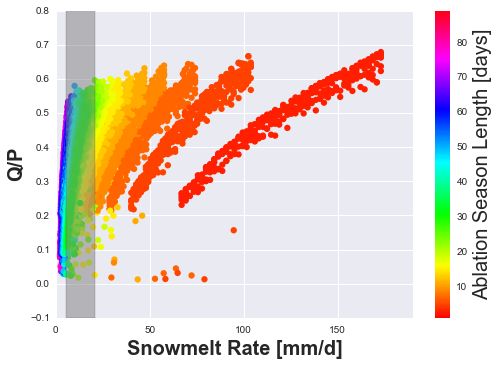

In [48]:
plt.axvspan(niwot.averageMR.min(), niwot.averageMR.max(), facecolor='0.5', alpha=0.5)
plt.scatter(data.SMR,data.RR,s = 40,lw=2,c=data.ASL, edgecolor='none',cmap='hsv')
plt.ylabel('Q/P', fontsize=20, weight='bold')
plt.xlabel('Snowmelt Rate [mm/d]', fontsize = 20, weight = 'bold')
cb = plt.colorbar()
cb.set_label('Ablation Season Length [days]', fontsize = 20)
plt.xlim(0,190)

In [22]:
data.loc[(data.SMR>150) & (data.RR<0.1),'Color'] = 'r' 

In [32]:
data.loc[(data.SMR>190) & (data.RR>0.2),'Color'] = 'g'

In [31]:
data.loc[(data.SMR>150) & (data.RR<0.1)].sort(columns='SMR').Pex

28700    495.400000
26952    517.179592
27854    521.359184
26006    571.938776
28706    534.338776
26957    549.628571
26959    562.608163
28712    573.277551
28713    579.767347
27866    599.236735
28717    605.726531
27869    618.706122
26019    656.306122
25020    671.795918
26972    646.975510
27875    657.644898
27877    670.624490
25029    730.204082
25031    743.183673
26982    711.873469
27884    716.053061
27887    735.522449
26988    750.812245
26989    757.302041
25039    795.102041
27889    748.502041
26992    776.771429
26043    812.061224
27893    774.461224
26995    796.240816
25045    834.040816
28745    787.440816
26047    838.020408
Name: Pex, dtype: float64

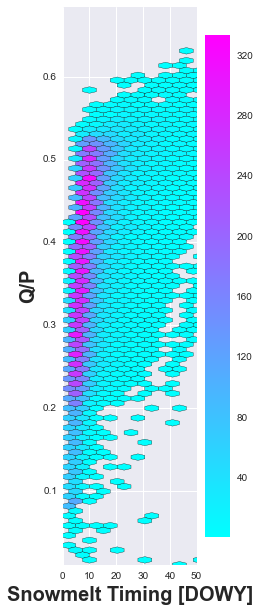

In [59]:
plt.figure(figsize=(3,10))
plt.hexbin(data.SMR,data.RR,gridsize=100,edgecolor='k',cmap='cool', mincnt=1)
plt.ylabel('Q/P', fontsize=20, weight='bold')
plt.xlabel('Snowmelt Timing [DOWY]', fontsize = 20, weight = 'bold')
plt.xlim(0,50)
cb = plt.colorbar()

In [34]:
data.loc[(data.SMR>190) & (data.RR>0.2)]

Tnosnow  TpeakSWE     peakSWE         SMR   ref   date_ONS  DOAS  \
25000      223       222  201.000000  201.000000  2008 2008-05-10    15   
25001      223       222  207.489796  207.489796  2008 2008-05-10    15   
25002      223       222  213.979592  213.979592  2008 2008-05-10    15   
25003      223       222  220.469388  220.469388  2008 2008-05-10    15   
25004      223       222  226.959184  226.959184  2008 2008-05-10    15   
25005      223       222  233.448980  233.448980  2008 2008-05-10    15   
25006      223       222  239.938776  239.938776  2008 2008-05-10    15   
25007      223       222  246.428571  246.428571  2008 2008-05-10    15   
25008      223       222  252.918367  252.918367  2008 2008-05-10    15   
25009      223       222  259.408163  259.408163  2008 2008-05-10    15   
25010      223       222  265.897959  265.897959  2008 2008-05-10    15   
25011      223       222  272.387755  272.387755  2008 2008-05-10    15   
25012      223       222  278.877551  278.877551  2008 2008-05-10    15   
25013      223       222  285.367347  285.367347  2008 2008-05-10    15   
25014      223       222  291.857143  291.857143  2008 2008-05-10    15   
25015      223       222  298.346939  298.346939  2008 2008-05-10    15   
25016      223       222  304.836735  304.836735  2008 2008-05-10    15   
25017      223       222  311.326531  311.326531  2008 2008-05-10    15   
25018      223       222  317.816327  317.816327  2008 2008-05-10    15   
25019      223       222  324.306122  324.306122  2008 2008-05-10    15   
25021      223       222  337.285714  337.285714  2008 2008-05-10    15   
25022      223       222  343.775510  343.775510  2008 2008-05-10    15   
25023      223       222  350.265306  350.265306  2008 2008-05-10    15   
25024      223       222  356.755102  356.755102  2008 2008-05-10    15   
25025      223       222  363.244898  363.244898  2008 2008-05-10    15   
25026      223       222  369.734694  369.734694  2008 2008-05-10    15   
25027      223       222  376.224490  376.224490  2008 2008-05-10    15   
25028      223       222  382.714286  382.714286  2008 2008-05-10    15   
25030      223       222  395.693878  395.693878  2008 2008-05-10    15   
25032      223       222  408.673469  408.673469  2008 2008-05-10    15   
...        ...       ...         ...         ...   ...        ...   ...   
28719      231       230  324.306122  324.306122  2008 2008-05-18    15   
28720      231       230  330.795918  330.795918  2008 2008-05-18    15   
28721      231       230  337.285714  337.285714  2008 2008-05-18    15   
28722      231       230  343.775510  343.775510  2008 2008-05-18    15   
28723      231       230  350.265306  350.265306  2008 2008-05-18    15   
28724      231       230  356.755102  356.755102  2008 2008-05-18    15   
28725      231       230  363.244898  363.244898  2008 2008-05-18    15   
28726      231       230  369.734694  369.734694  2008 2008-05-18    15   
28727      231       230  376.224490  376.224490  2008 2008-05-18    15   
28728      231       230  382.714286  382.714286  2008 2008-05-18    15   
28729      231       230  389.204082  389.204082  2008 2008-05-18    15   
28730      231       230  395.693878  395.693878  2008 2008-05-18    15   
28731      231       230  402.183673  402.183673  2008 2008-05-18    15   
28732      231       230  408.673469  408.673469  2008 2008-05-18    15   
28733      231       230  415.163265  415.163265  2008 2008-05-18    15   
28734      231       230  421.653061  421.653061  2008 2008-05-18    15   
28735      231       230  428.142857  428.142857  2008 2008-05-18    15   
28736      231       230  434.632653  434.632653  2008 2008-05-18    15   
28737      231       230  441.122449  441.122449  2008 2008-05-18    15   
28738      231       230  447.612245  447.612245  2008 2008-05-18    15   
28739      231       230  454.102041  454.102041  2008 2008-05-18    15   
28740      231       230  460.59

In [126]:
import statsmodels.formula.api as sm

In [127]:
print niwot.averageMR.min()
print niwot.averageMR.max()

5.72340425532
20.6666666667


In [128]:
data['ln_SMR'] = np.log(data.SMR)

In [134]:
data2 = pd.DataFrame()

keys = ['RR','Tnosnow','SMR','TPeakSWE','ln_SMR','sat_def','rz_drainage','PeakSWE']

for key in keys:    
    data2[key] = standardize(data[key])

## Clean Data

In [135]:
data2.head()

RR   Tnosnow       SMR  TpeakSWE    ln_SMR   sat_def  rz_drainage  \
0 -1.154629 -2.015366 -1.362972 -1.515445 -1.558162  1.037336    -1.026354   
1 -1.087629 -2.015366 -1.324488 -1.515445 -1.490949  0.991725    -0.974693   
2 -1.023433 -2.015366 -1.286004 -1.515445 -1.425338  0.945222    -0.921988   
3 -0.974118 -2.015366 -1.247521 -1.515445 -1.361254  0.898910    -0.868492   
4 -0.897325 -2.015366 -1.209037 -1.515445 -1.298629  0.841334    -0.818029   

    peakSWE  
0 -1.575383  
1 -1.521187  
2 -1.466990  
3 -1.412794  
4 -1.358598

In [131]:
data2['sat_def2'] = data2.sat_def**2

In [139]:
mod1 = sm.ols('RR ~ SMR + Tnosnow + TPeakSWE + PeakSWE +1',data2).fit()
print mod1.summary()

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                 2.308e+05
Date:                Tue, 14 Jul 2015   Prob (F-statistic):               0.00
Time:                        11:13:35   Log-Likelihood:                -30431.
No. Observations:              106676   AIC:                         6.087e+04
Df Residuals:                  106671   BIC:                         6.092e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   9.805e-15      0.001   9.95e-12      1.0

In [140]:
mod2 = sm.ols('SMR ~ PeakSWE +1',data2).fit()
print mod2.summary()

                            OLS Regression Results                            
Dep. Variable:                    SMR   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                 3.066e+04
Date:                Tue, 14 Jul 2015   Prob (F-statistic):               0.00
Time:                        11:13:36   Log-Likelihood:            -1.3789e+05
No. Observations:              106676   AIC:                         2.758e+05
Df Residuals:                  106674   BIC:                         2.758e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   6.672e-15      0.003   2.47e-12      1.0

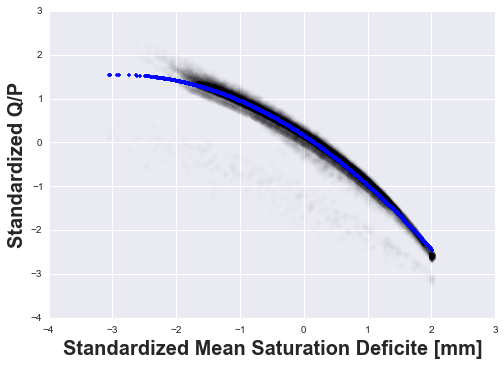

In [47]:
plt.plot(data2.sat_def,data2.RR,'ok', alpha = 0.01)
plt.plot(mod.model.data.exog[:,1],mod.fittedvalues,'.b')
plt.xlabel('Standardized Mean Saturation Deficite [mm]', fontsize=20, weight='bold')
plt.ylabel('Standardized Q/P', fontsize=20,weight='bold')

In [43]:
x = np.linspace(-4,3,1000)
xnew = np.c_[np.ones_like(x),x,x**2,]

In [46]:
1.23126917**2

1.516023768992489

In [42]:
mod.model.data.exog

array([[ 1.        ,  1.23126917,  1.51602378],
       [ 1.        ,  1.1454793 ,  1.31212284],
       [ 1.        ,  1.09894107,  1.20767148],
       ..., 
       [ 1.        , -1.13064183,  1.27835096],
       [ 1.        , -1.32309526,  1.75058107],
       [ 1.        , -1.10173032,  1.21380969]])

In [45]:
xnew

array([[  1.        ,  -4.        ,  16.        ],
       [  1.        ,  -3.99299299,  15.94399304],
       [  1.        ,  -3.98598599,  15.88808428],
       ..., 
       [  1.        ,   2.98598599,   8.91611231],
       [  1.        ,   2.99299299,   8.95800706],
       [  1.        ,   3.        ,   9.        ]])

In [44]:
mod.predict(xnew)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [51]:
import glob

In [52]:
files = glob.glob('/Volumes/data/RHESSys_out/smex2/smex2_*_patch.daily')

In [53]:
files

['/Volumes/data/RHESSys_out/smex2/smex2_0_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10000_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10001_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10002_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10003_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10004_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10005_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10006_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10007_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10008_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10009_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_1000_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10010_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10011_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10012_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10013_patch.daily',
 '/Volumes/data/RHESSys_out/smex2/smex2_10014

In [54]:
fl = files[-10]

In [56]:
int(fl.split('_')[-2])

'9993'

In [145]:
tmp = pd.read_table(fl, delim_whitespace=True)

In [148]:
print list(tmp.columns)

['day', 'month', 'year', 'basinID', 'hillID', 'zoneID', 'patchID', 'rain_thr', 'detention_store', 'sat_def_z', 'sat_def', 'rz_storage', 'potential_rz_store', 'rz_field_capacity', 'rz_wilting_point', 'unsat_stor', 'rz_drainage', 'unsat_drain', 'sublimation', 'return', 'evap', 'evap_surface', 'soil_evap', 'snow', 'snow_melt', 'trans_sat', 'trans_unsat', 'Qin', 'Qout', 'psn', 'root_zone.S', 'root.depth', 'litter.rain_stor', 'litter.S', 'area', 'pet', 'lai', 'baseflow', 'streamflow', 'pcp', 'recharge', 'Kdowndirpch', 'Kdowndiffpch', 'Kupdirpch', 'Kupdifpch', 'Luppch', 'Kdowndirsubcan', 'Kdowndifsubcan', 'Ldownsubcan', 'Kstarcan', 'Kstardirsno', 'Kstardiffsno', 'Lstarcanopy', 'Lstarsnow', 'Lstarsoil', 'wind', 'windsnow', 'windzone', 'ga', 'gasnow', 'trans_reduc_perc', 'pch_field_cap', 'overland_flow', 'height', 'ustar', 'snow_albedo', 'Kstarsoil', 'Kdowndirsurf', 'Kdowndifsurf', 'exfil_unsat', 'snow_Rnet', 'snow_QLE', 'snow_QH', 'snow_Qrain', 'snow_Qmelt', 'LEcanopy', 'SED', 'snow_age']


In [ ]:
def process_Patch(fl):
    
    num = int(fl.split('_')[-2]) # split out the file number
    
    data = pd.read_table(fl, delim_whitespace=True) # load the patch data
    
    rz_storage = data.rz_storage.mean() # root zone storage
    rz_field_capacity = data.rz_field_capacity.mean() # root zone field capacity
    rz_drainage = data.rz_drainage.mean() # root zone drainage 
    unsat_drainage = data.unsat_drain.mean() # unsaturated zone drainage
    sat_def = data.sat_def.mean() # saturation deficite (mm)
    sat_def_z = data.sat_def_z.mean() # saturation deficite depth, is this the depth to ground water?
    
    
    
    